# Preferential Bayesian Optimization: Predictive Entropy Search
This notebook demonstrates the use of the Predictive Entropy Search (PES) acquisition function on ordinal (preference) data. 

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
objective = PBO.objectives.six_hump_camel
objective_low = -1.5
objective_high = 1.5
objective_name = "SHC"
acquisition_name = "PES"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [3]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 2
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 1000 # Discretization of continuous input space

In [4]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/PES/results/PBO_PES_SHC/  already exists


Plot of the SHC function (global min at at x = [0.0898, -0.7126] and x = [-0.0898, 0.7126]):

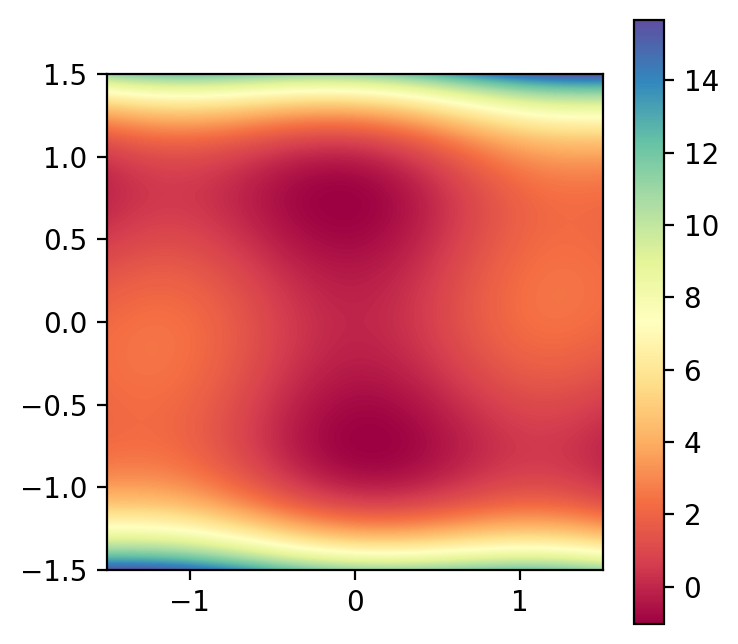

In [5]:
side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
X,Y = np.meshgrid(side,side)
combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
fvals = objective(combs)
preds = tf.transpose(tf.reshape(fvals, [num_discrete_per_dim, num_discrete_per_dim]))
plt.figure(figsize=(4, 4), dpi=200)
plt.imshow(preds, 
           interpolation='nearest', 
           extent=(objective_low, objective_high, objective_low, objective_high), 
           origin='lower', 
           cmap='Spectral')
plt.colorbar()

In [6]:
def plot_gp(model, inducing_points, inputs, title, cmap="Spectral"):

    side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
    combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
    predictions = model.predict_y(combs)
    preds = tf.transpose(tf.reshape(predictions[0], [num_discrete_per_dim, num_discrete_per_dim]))
    variances = tf.transpose(tf.reshape(predictions[1], [num_discrete_per_dim, num_discrete_per_dim]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    fig.set_size_inches(18.5, 6.88)
    fig.set_dpi((200))

    ax1.axis('equal')
    im1 = ax1.imshow(preds, 
                     interpolation='nearest', 
                     extent=(objective_low, objective_high, objective_low, objective_high), 
                     origin='lower', 
                     cmap=cmap)
    ax1.plot(inducing_points[:, 0], inducing_points[:, 1], 'kx', mew=2)
    ax1.plot(inputs[:, 0], inputs[:, 1], 'ko', mew=2, color='w')
    ax1.set_title("Mean")
    ax1.set_xlabel("x0")
    ax1.set_ylabel("x1")
    fig.colorbar(im1, ax=ax1)

    ax2.axis('equal')
    im2 = ax2.imshow(variances, 
                     interpolation='nearest', 
                     extent=(objective_low, objective_high, objective_low, objective_high), 
                     origin='lower', 
                     cmap=cmap)
    ax2.plot(inducing_points[:, 0], inducing_points[:, 1], 'kx', mew=2)
    ax2.plot(inputs[:, 0], inputs[:, 1], 'ko', mew=2, color='w')
    ax2.set_title("Variance")
    ax2.set_xlabel("x0")
    ax2.set_ylabel("x1")
    fig.colorbar(im2, ax=ax2)

    plt.savefig(fname=results_dir + title + ".png")
    plt.show()

In [7]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [8]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k, indifference_threshold = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         num_steps=3000)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, inputs, title)
    
    return model, inputs, u_mean, inducing_vars

In [9]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the global minimum, the better.

In [10]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [11]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [12]:
np.random.seed(0)
init_points = np.random.uniform(size=[num_runs, num_init_points, input_dims], low=objective_low, high=objective_high)
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

Beginning run 0
Indifference_threshold is trainable.
Instructions for updating:
Use tf.identity instead.
Negative ELBO at step 0: 2.7462530453146083 in 0.1381s
Negative ELBO at step 500: 2.151247167956027 in 40.2873s
Negative ELBO at step 1000: 2.050255008360218 in 39.6370s
Negative ELBO at step 1500: 2.00676135574421 in 40.7583s
Negative ELBO at step 2000: 1.9221452750432528 in 39.9244s
Negative ELBO at step 2500: 1.8126594319256064 in 39.8988s


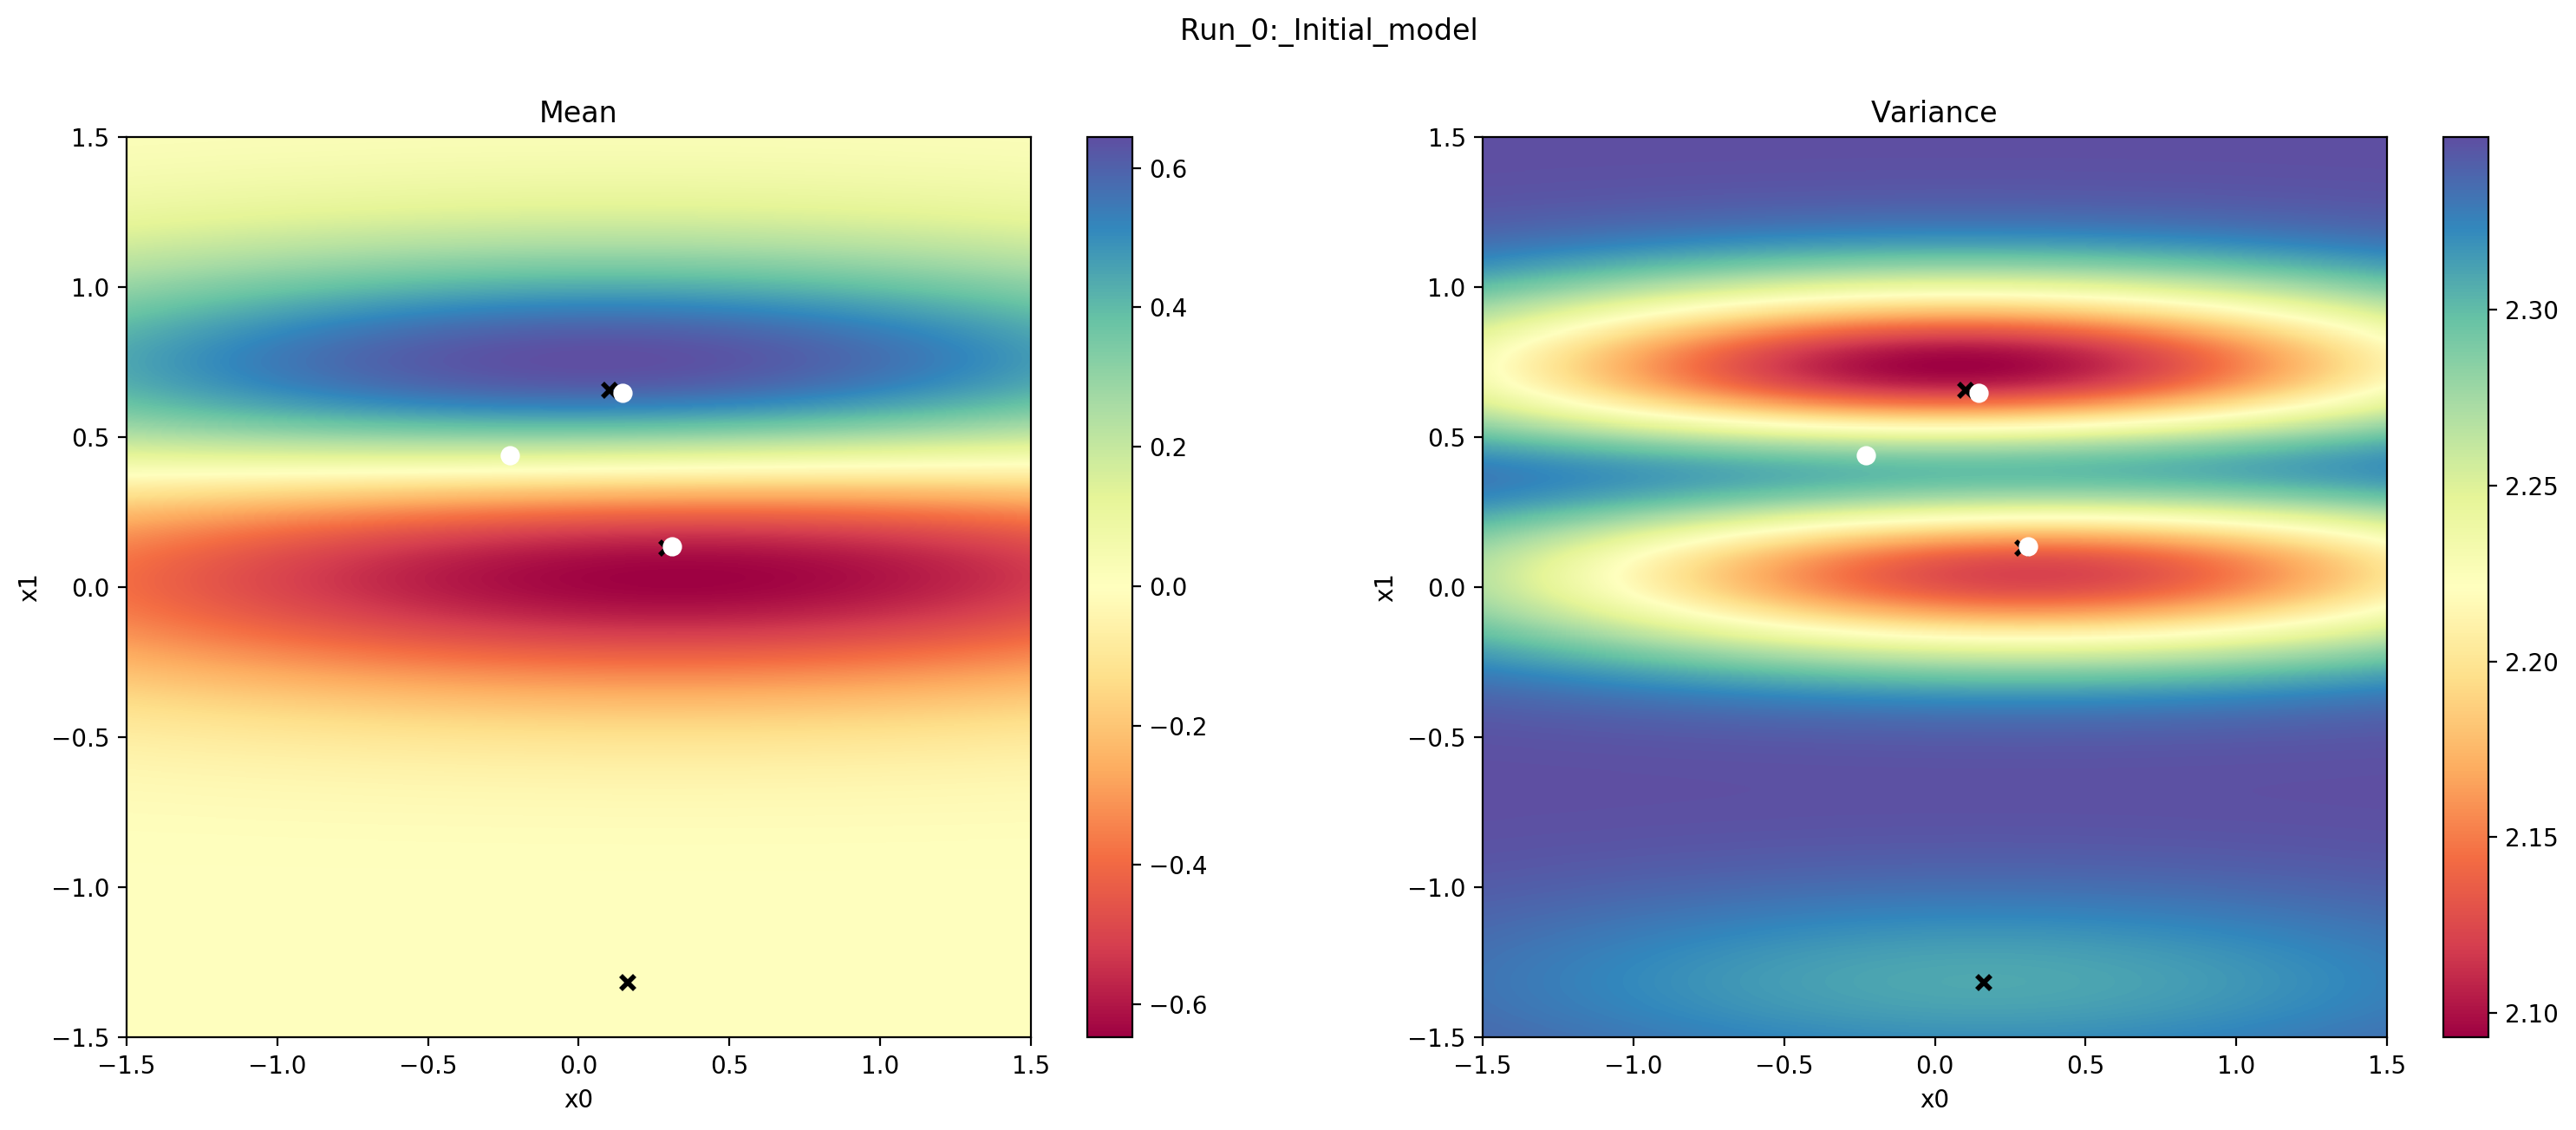

Beginning evaluation 0
Evaluation 0: Sampling maximizers
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Loss at step 0: 37.54108721832166
Loss at step 500: -168.72390596651763
Loss at step 1000: -195.05253334864034
Loss at step 1500: -195.51802009106353
Loss at step 1838: -195.52963138540971
tf.Tensor(
[[0.         0.56497717]
 [1.         0.34781054]
 [1.         0.85557147]
 [0.         1.        ]
 [0.         0.25112214]
 [0.00432726 0.55773473]
 [1.         1.        ]
 [0.         1.        ]
 [1.         1.        ]
 [1.         0.52683599]
 [1.         0.99654684]
 [0.31254432 1.        ]
 [0.         0.71313795]
 [0.18347276 1.        ]
 [0.         0.7730907 ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.92206324]
 [1.         1.        ]
 [1.         1.        ]], shape=(20, 2), dtype=float64)
Evaluation 0: Calculating I
Evaluatio

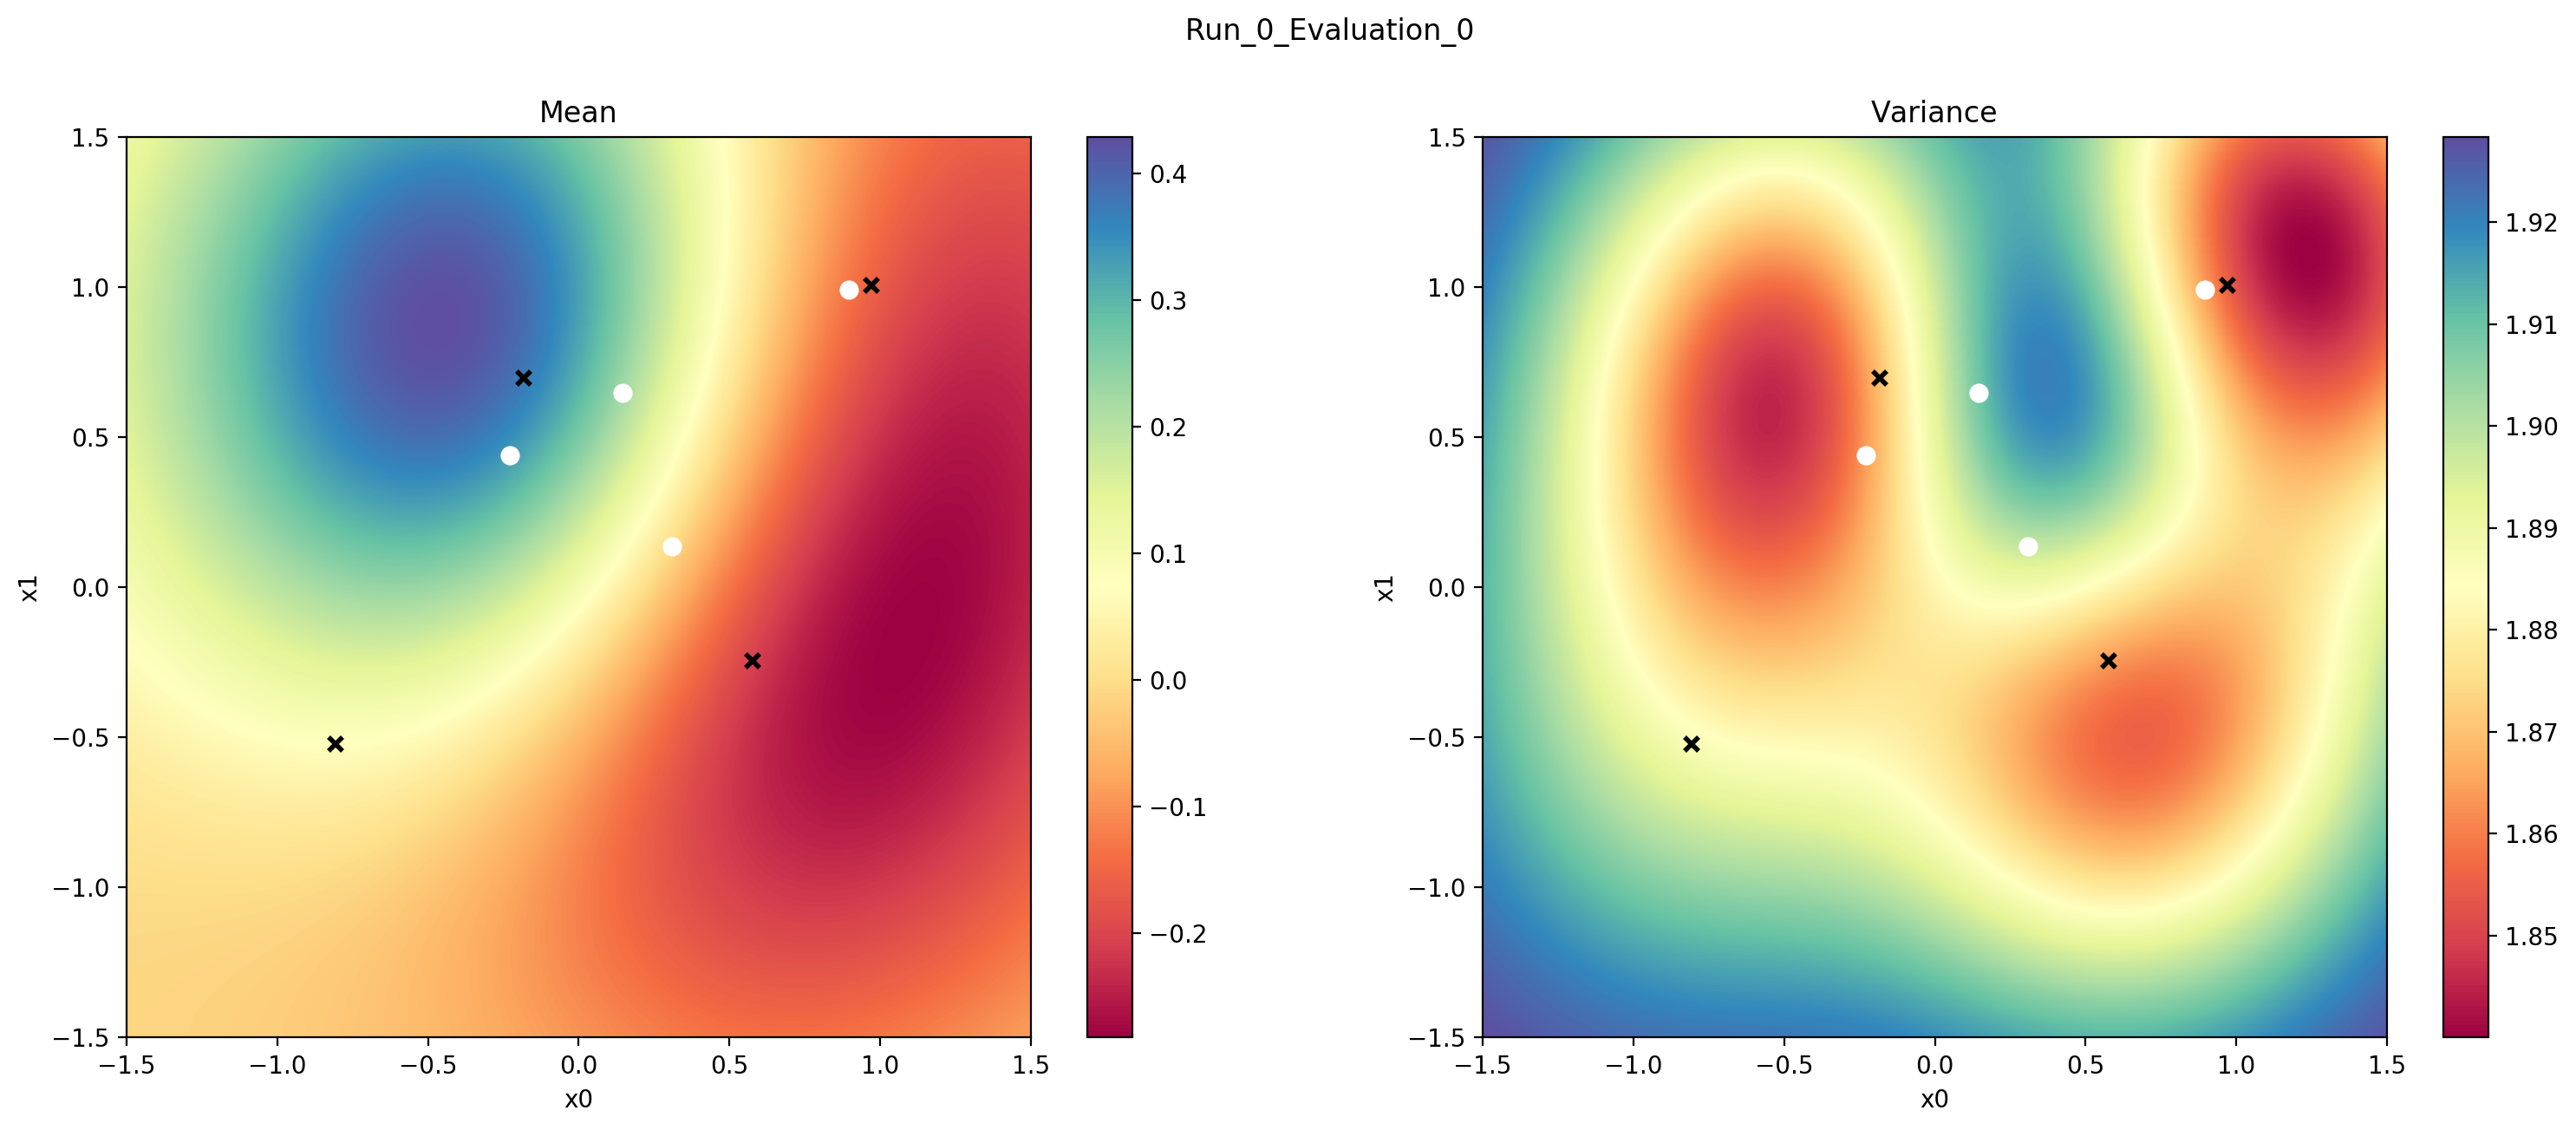

Beginning evaluation 1
Evaluation 1: Sampling maximizers
Loss at step 0: -16.245818774354262
Loss at step 500: -125.23173052837711
Loss at step 1000: -141.71846311182134
Loss at step 1500: -142.98379377074937
Loss at step 2000: -143.0649144510263
Loss at step 2076: -143.06630880699532
tf.Tensor(
[[0.83568273 0.21293032]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.54749651]
 [0.         0.        ]
 [1.         0.51672141]
 [0.93635279 1.        ]
 [1.         0.79500943]
 [0.         0.8562102 ]
 [1.         1.        ]
 [1.         0.        ]
 [0.47785749 1.        ]
 [0.         0.96268539]
 [1.         1.        ]
 [0.03070938 0.73088789]
 [0.6128364  0.71848304]
 [0.         0.        ]
 [0.         1.        ]
 [0.         0.75308919]
 [1.         1.        ]], shape=(20, 2), dtype=float64)
Evaluation 1: Calculating I
Evaluation 1: Next query is tf.Tensor(
[[0.89667129 0.99033895]
 [0.01203622 0.1154843 ]], shape=(2, 2), dtype=float64) with I value of 0.05257

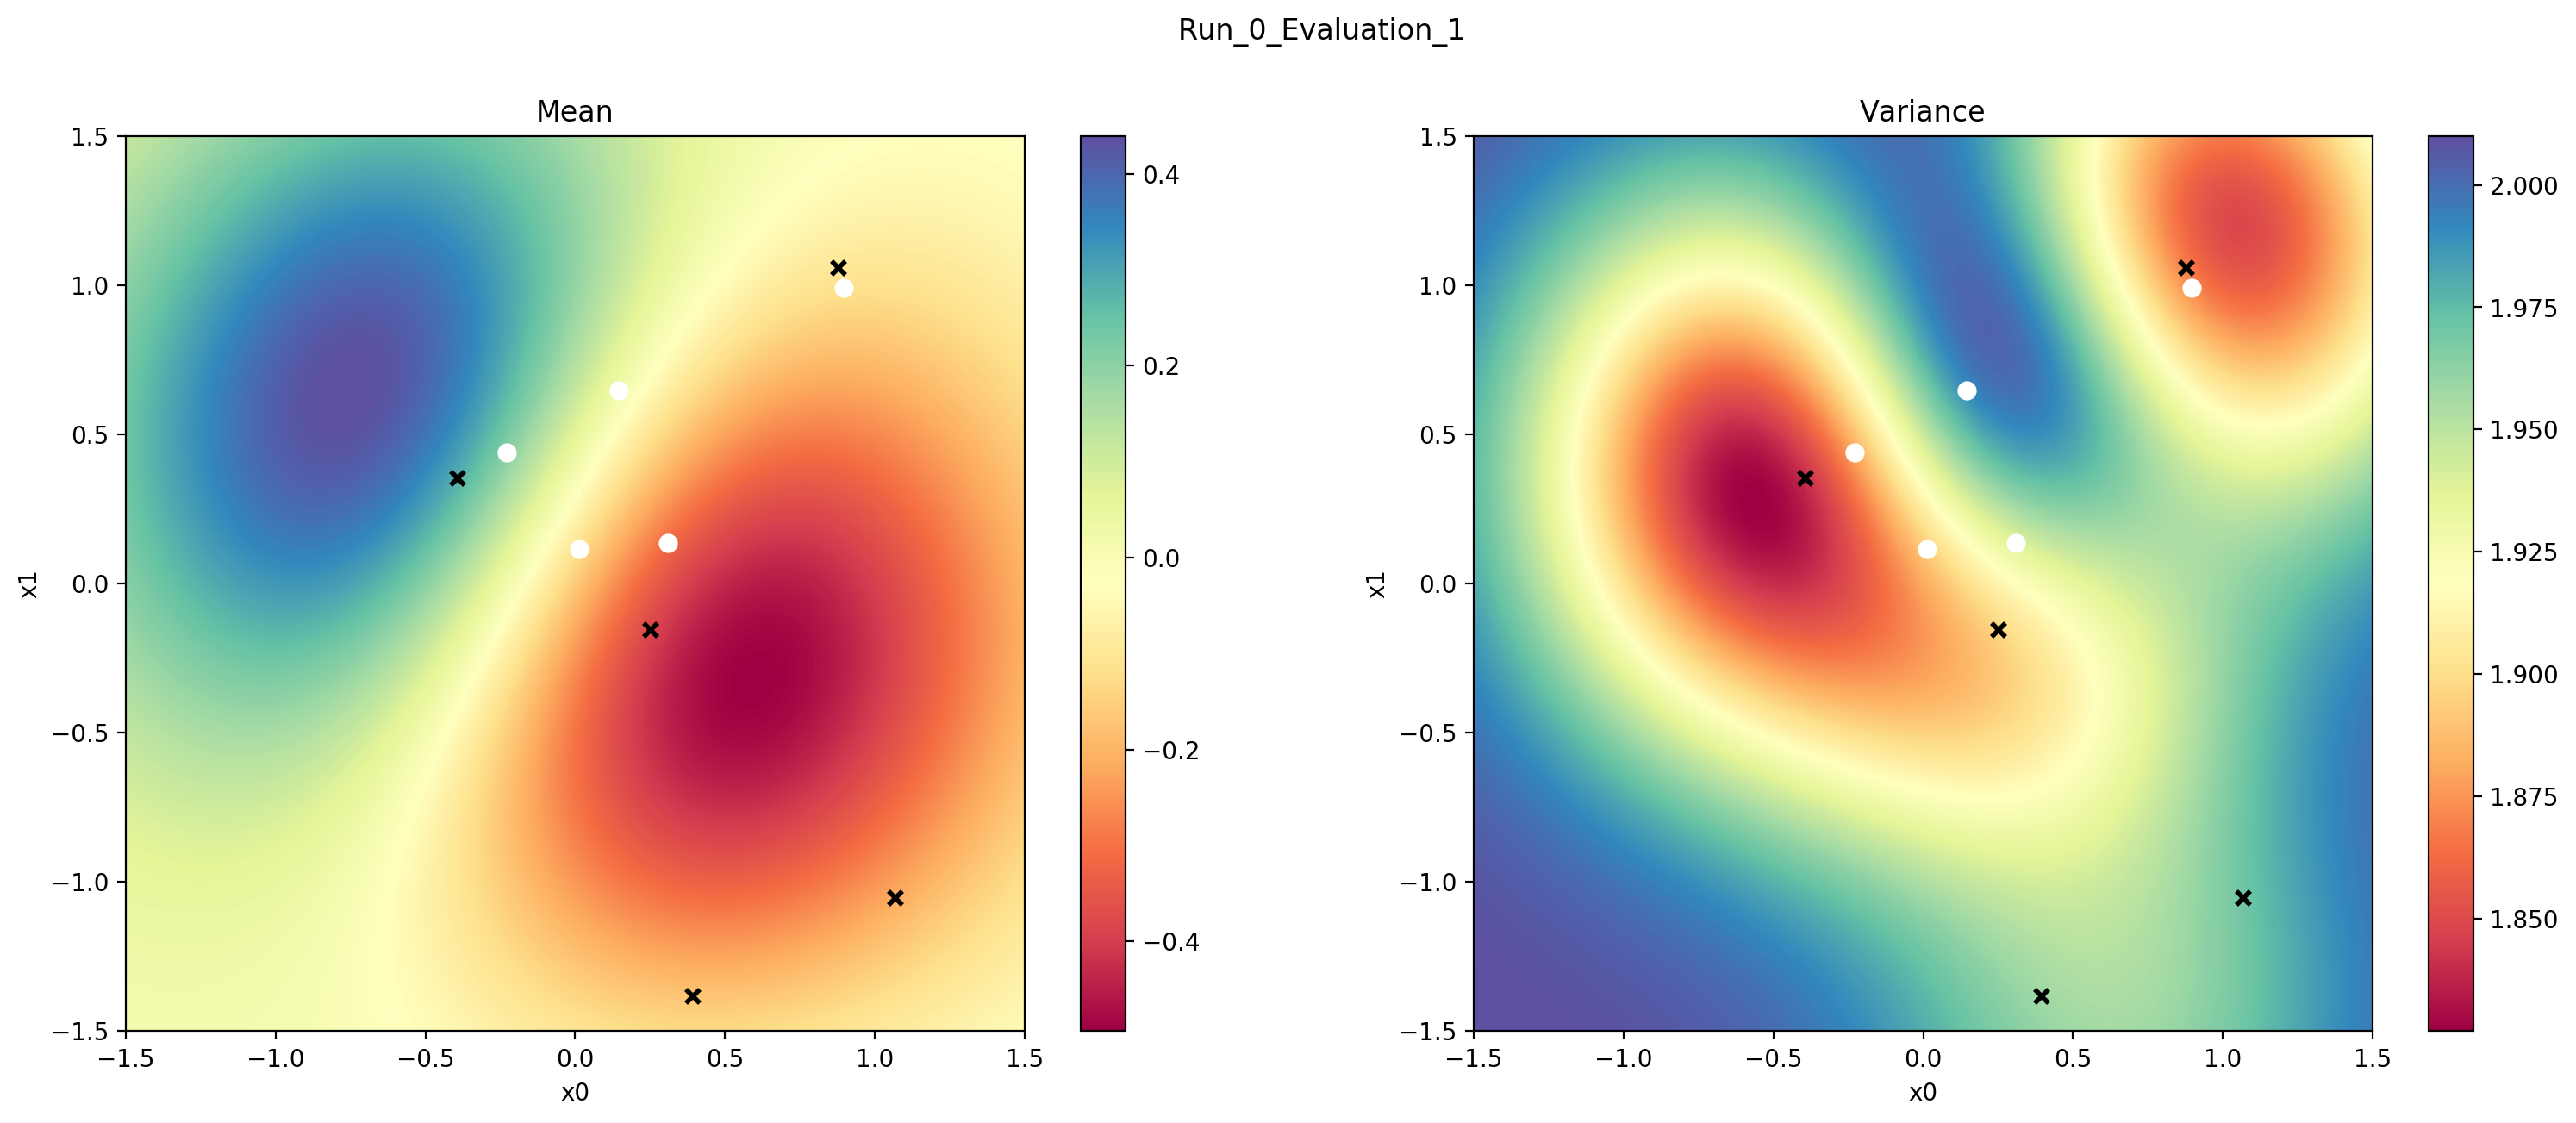

Beginning evaluation 2
Evaluation 2: Sampling maximizers
Loss at step 0: 25.112633016963766
Loss at step 500: -93.18925518668198
Loss at step 1000: -113.01502336565211
Loss at step 1500: -113.37971098907997
Loss at step 1968: -113.39999387577552
tf.Tensor(
[[0.29619798 1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [0.50512913 0.70539509]
 [0.         1.        ]
 [0.79156621 1.        ]
 [1.         1.        ]
 [0.91560051 1.        ]
 [1.         1.        ]
 [0.1413302  0.        ]
 [0.07810341 1.        ]
 [1.         1.        ]
 [0.87950559 1.        ]
 [1.         1.        ]
 [0.         0.59874754]
 [0.         1.        ]
 [1.         0.84981013]
 [0.54457948 0.51127936]
 [1.         1.        ]
 [1.         1.        ]], shape=(20, 2), dtype=float64)
Evaluation 2: Calculating I
Evaluation 2: Next query is tf.Tensor(
[[-0.2290356   0.43768234]
 [ 0.98058013  0.87178573]], shape=(2, 2), dtype=float64) with I value of 0.056324876690432964
Evaluation 2: Training

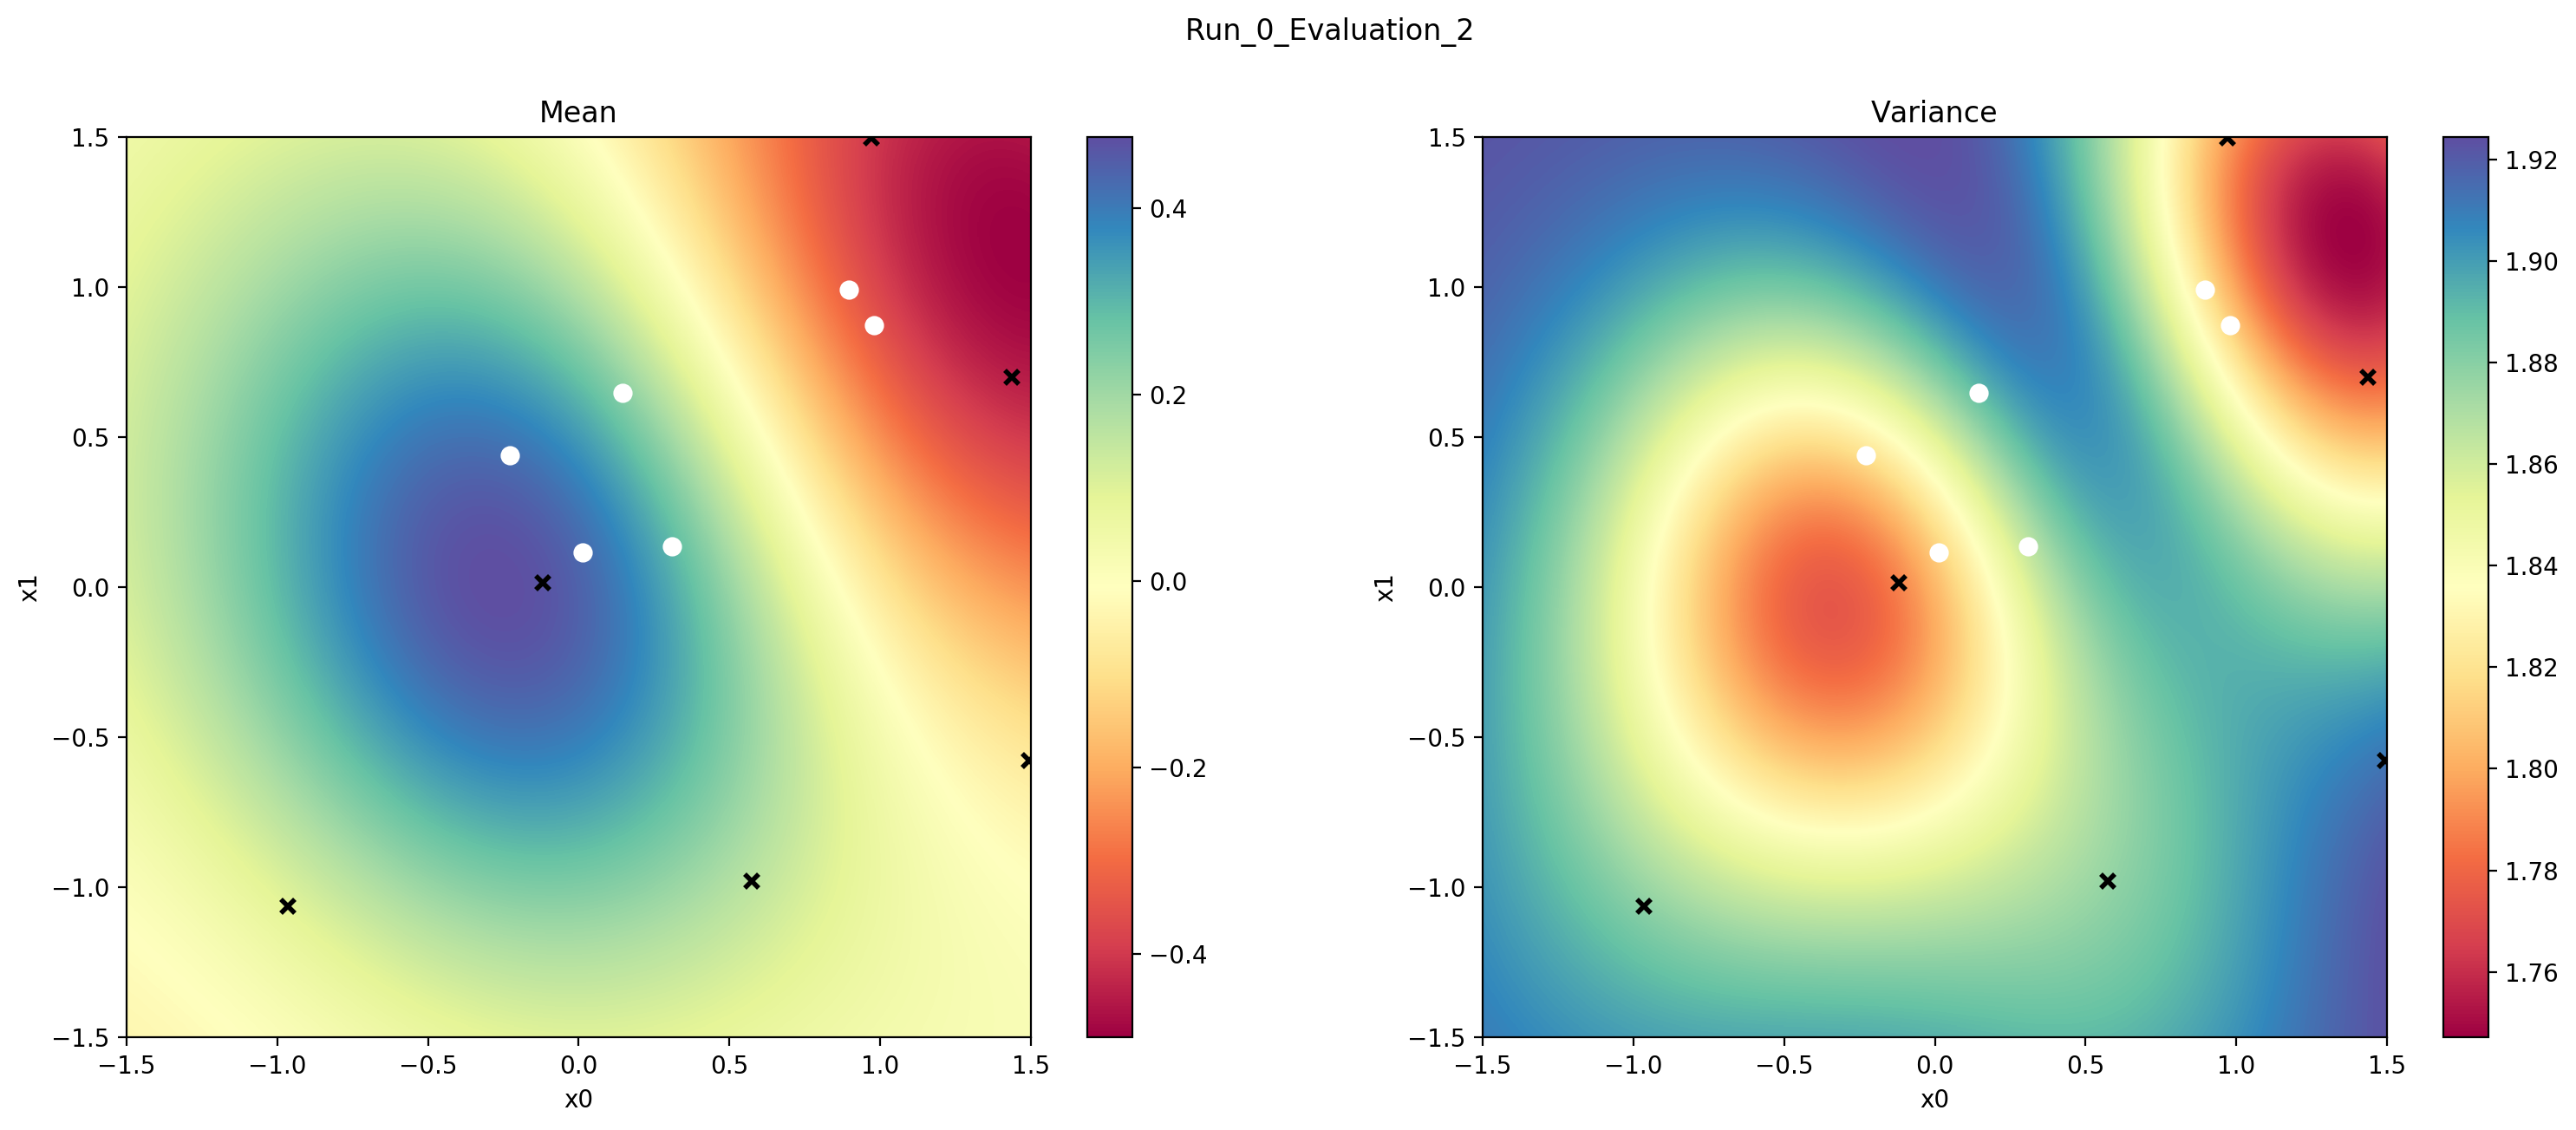

Beginning evaluation 3
Evaluation 3: Sampling maximizers
Loss at step 0: -42.461549781078205
Loss at step 500: -153.99106069716203
Loss at step 1000: -179.8490111984579
Loss at step 1500: -181.1127115213263
Loss at step 2000: -181.92896279872934
Loss at step 2500: -182.50997180168457
Loss at step 2594: -182.67816766511584
tf.Tensor(
[[0.         1.        ]
 [1.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.74062379]
 [0.         1.        ]
 [0.         0.40943785]
 [1.         1.        ]
 [0.         0.84324194]
 [0.30391204 1.        ]
 [1.         0.35693444]
 [1.         1.        ]
 [0.         0.0866401 ]
 [1.         1.        ]
 [0.         0.97092572]
 [0.         0.        ]
 [0.40256501 1.        ]
 [1.         1.        ]], shape=(20, 2), dtype=float64)
Evaluation 3: Calculating I
Evaluation 3: Next query is tf.Tensor(
[[-0.2290356   0.43768234]
 [ 0.98048566  0.09645086]], shape=(2, 

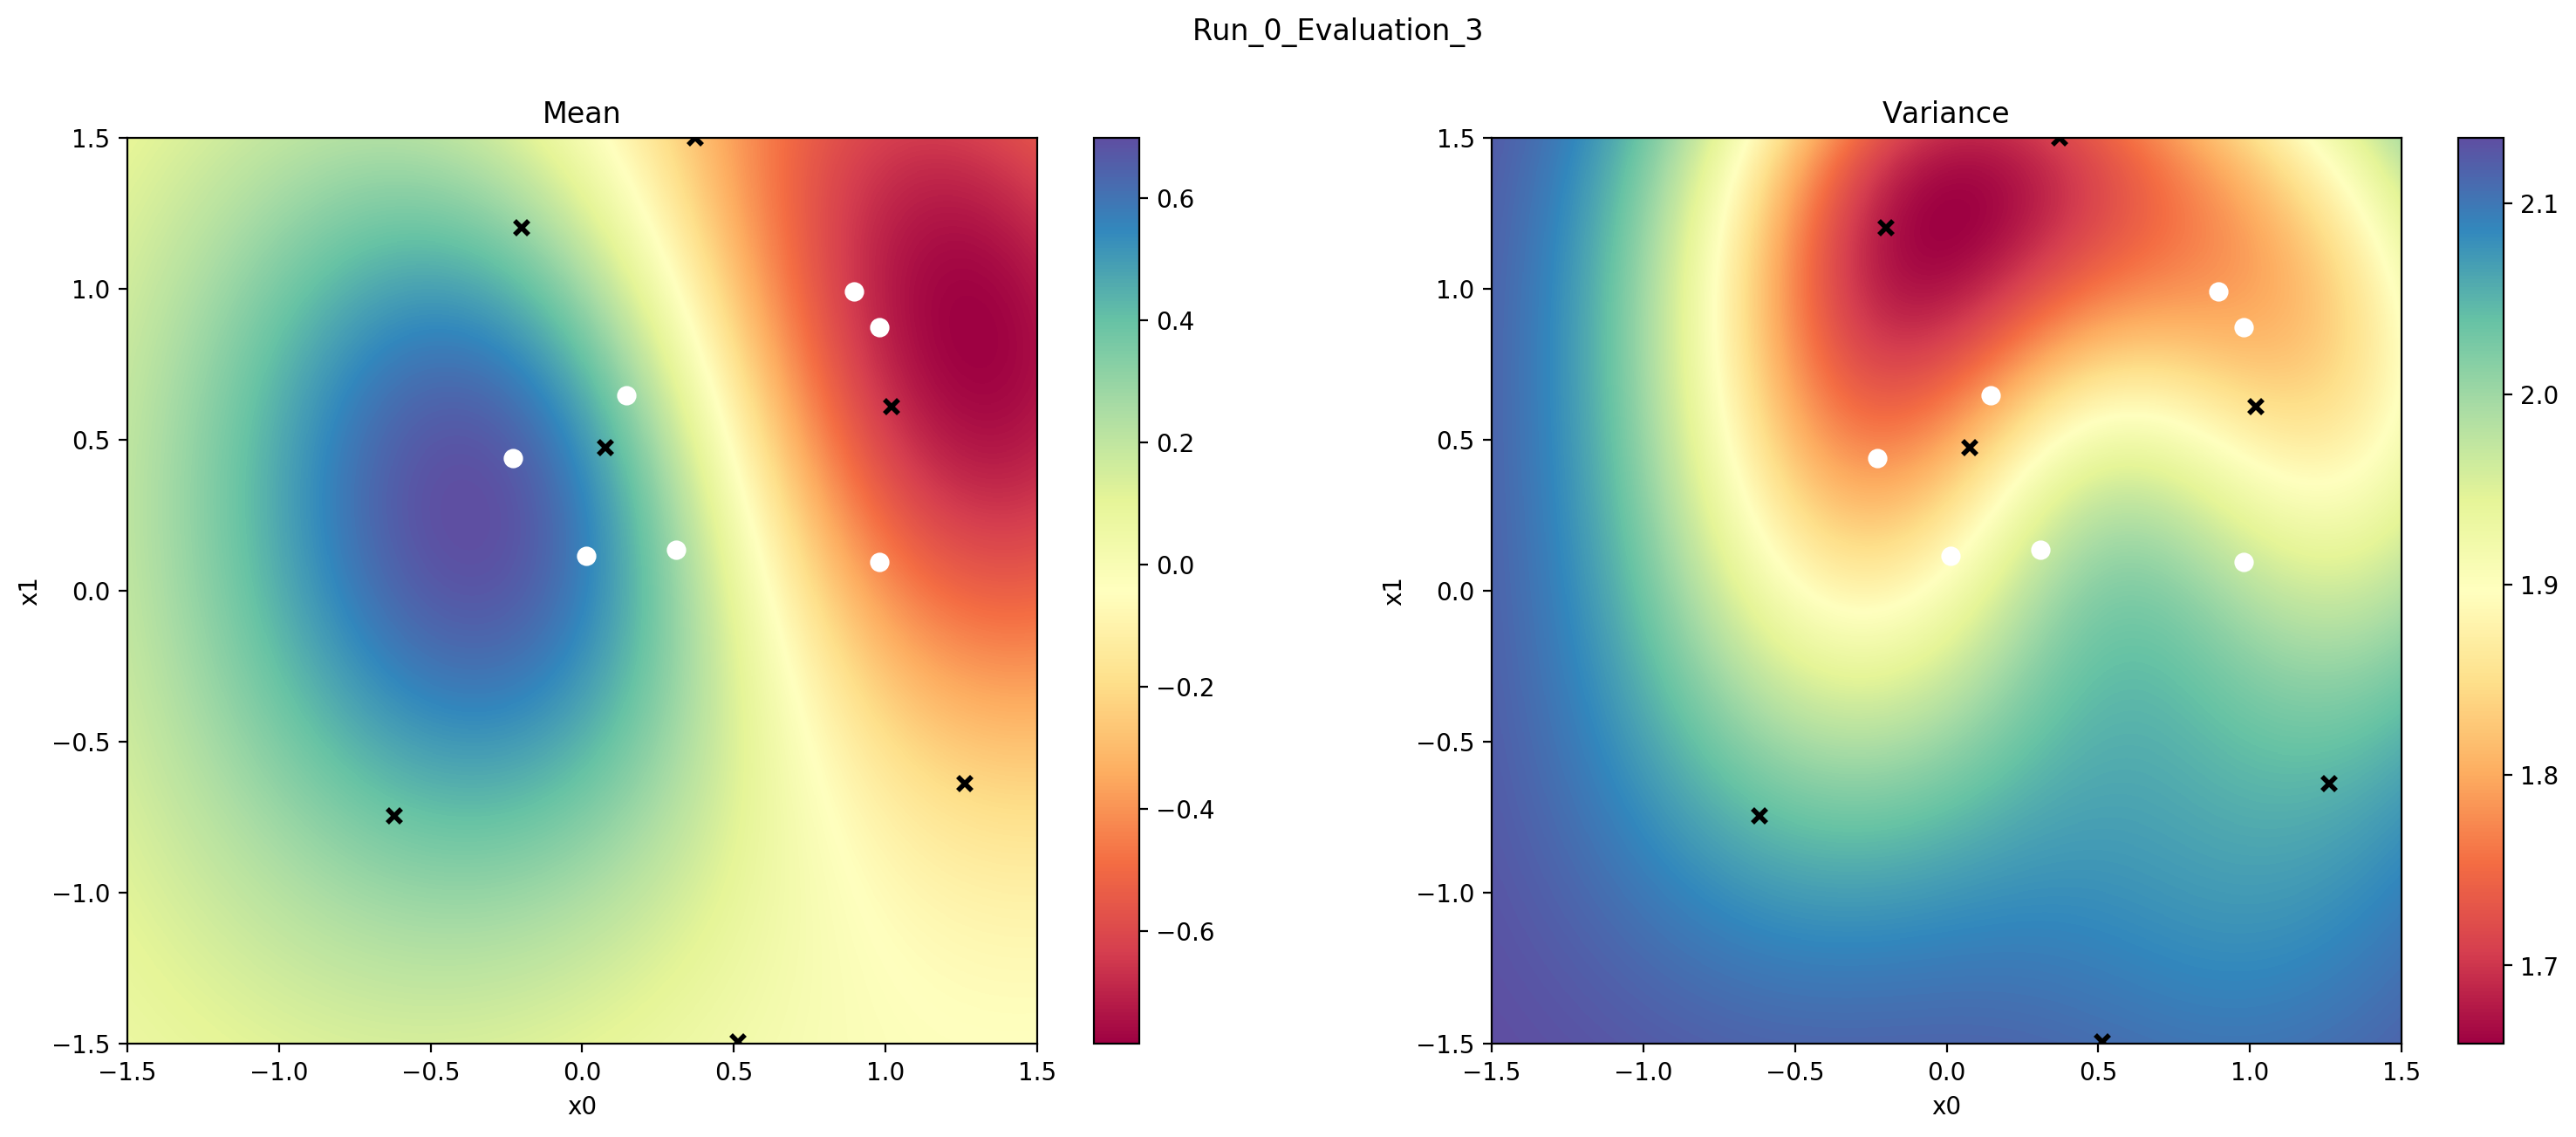

Beginning evaluation 4
Evaluation 4: Sampling maximizers
Loss at step 0: -34.68112990037202
Loss at step 500: -175.0413417631301
Loss at step 1000: -200.98421519978888
Loss at step 1500: -202.1137255543754
Loss at step 1766: -202.1673499005843
tf.Tensor(
[[0.10140576 0.20516872]
 [1.         1.        ]
 [1.         0.58829395]
 [0.         1.        ]
 [0.         0.        ]
 [0.7006627  0.        ]
 [1.         0.        ]
 [0.         0.56161369]
 [0.         1.        ]
 [1.         0.50366249]
 [0.29182944 1.        ]
 [0.         0.8450369 ]
 [0.         0.58637594]
 [1.         1.        ]
 [1.         0.        ]
 [0.65230591 1.        ]
 [0.33897959 1.        ]
 [0.09697768 0.        ]
 [1.         1.        ]
 [0.27116264 0.        ]], shape=(20, 2), dtype=float64)
Evaluation 4: Calculating I
Evaluation 4: Next query is tf.Tensor(
[[0.98048566 0.09645086]
 [0.19891133 0.95612316]], shape=(2, 2), dtype=float64) with I value of 0.04558671005934099
Evaluation 4: Training model


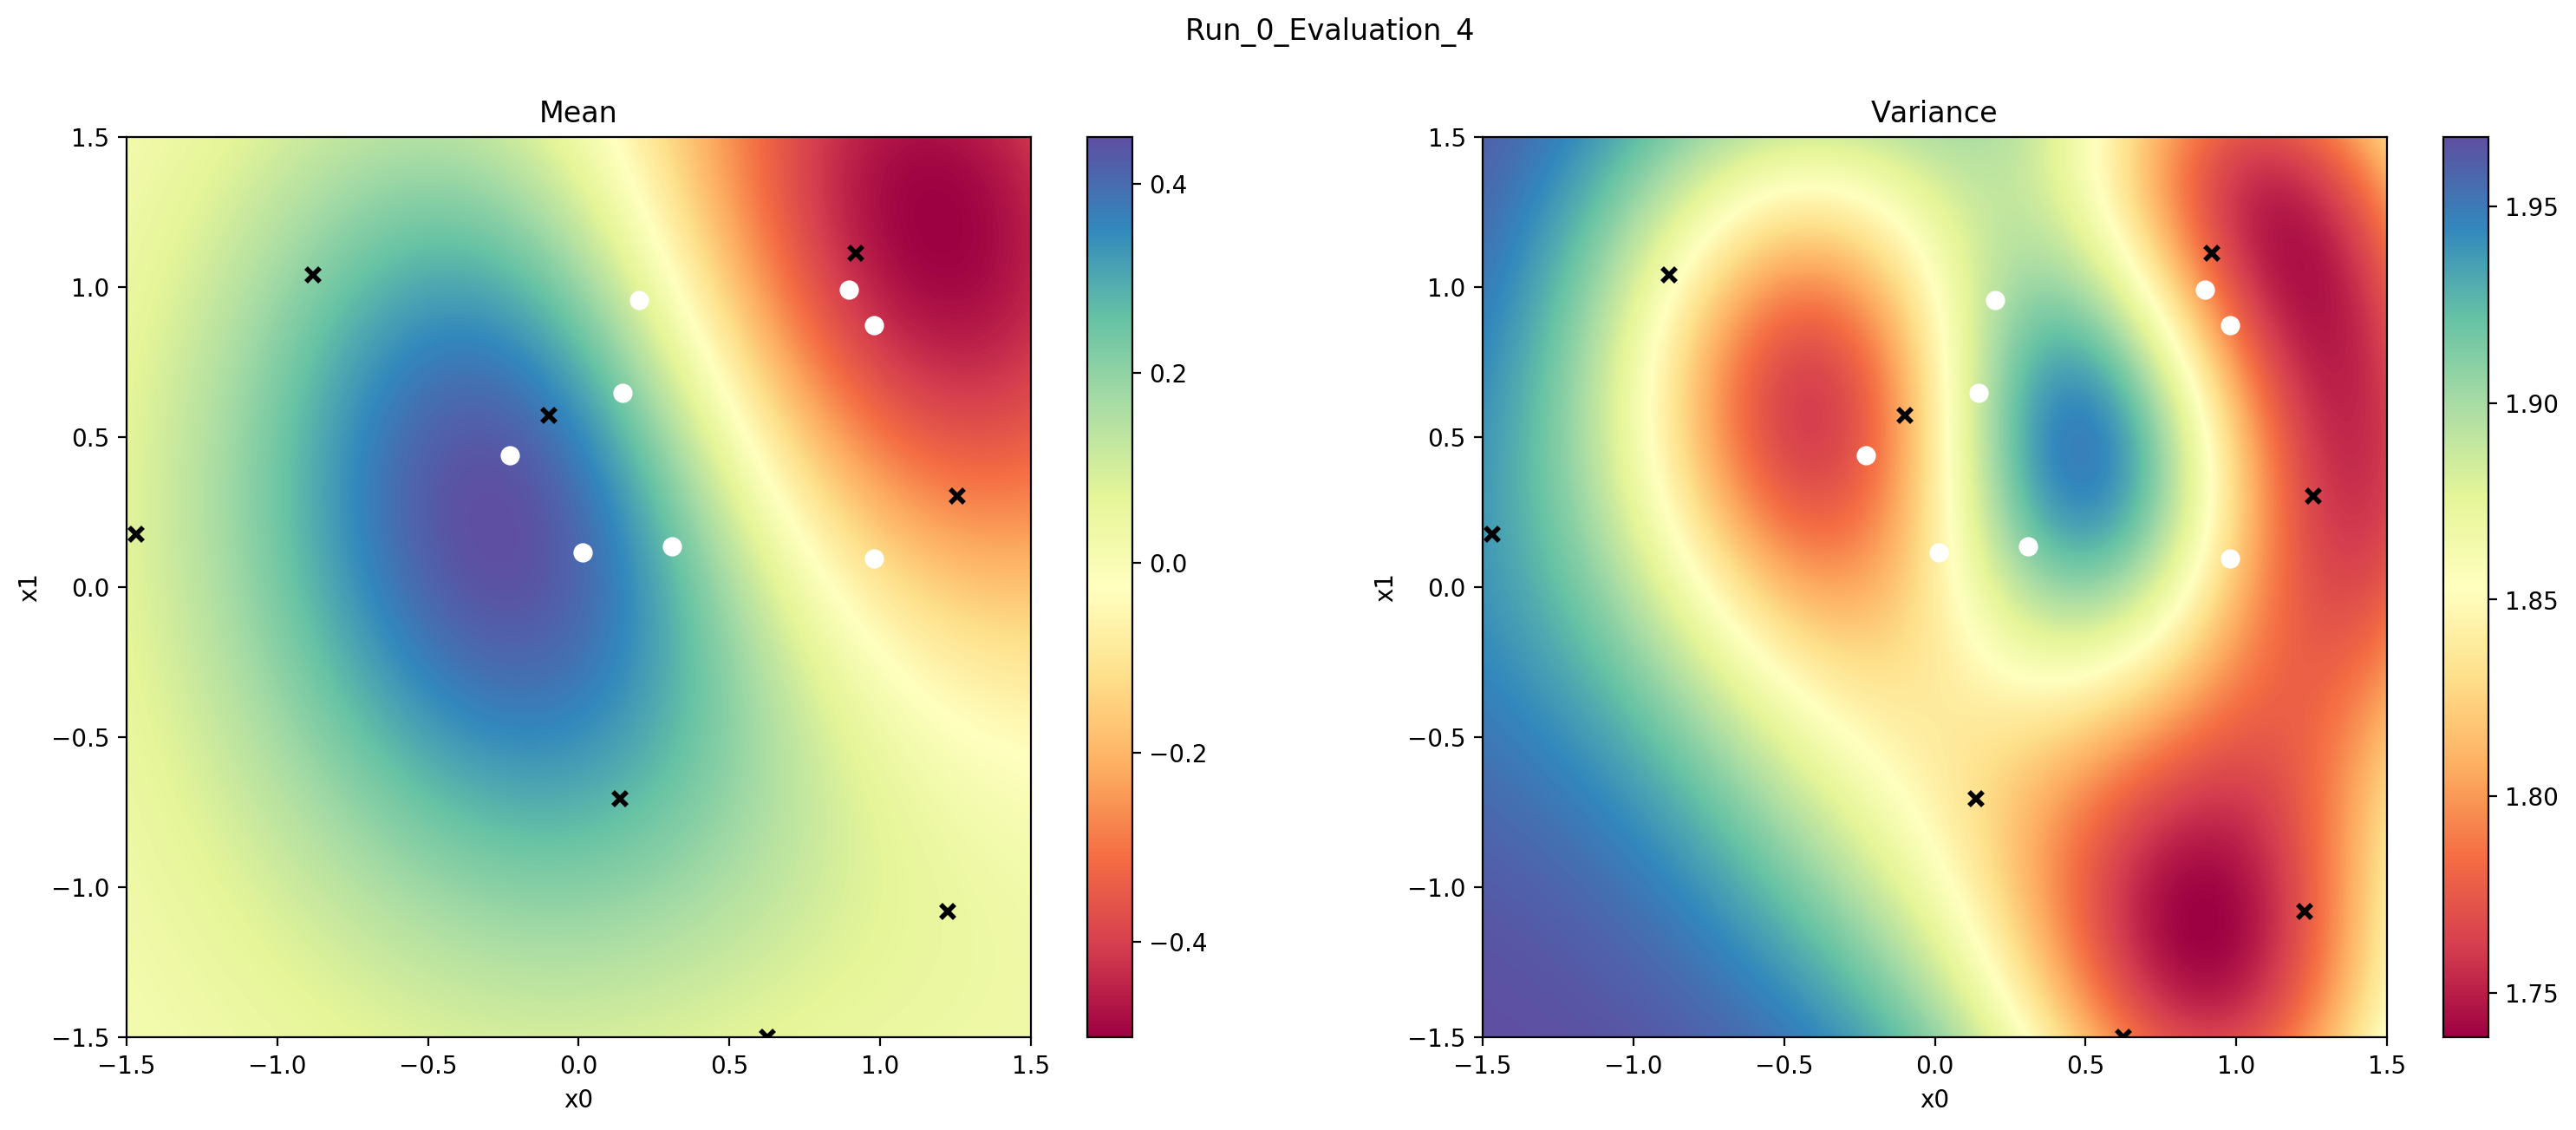

Beginning evaluation 5
Evaluation 5: Sampling maximizers
Loss at step 0: 55.48770996901257
Loss at step 500: -88.92566601696379
Loss at step 1000: -103.60753776631492
Loss at step 1500: -104.07862283838958
Loss at step 1924: -104.09807564405492
tf.Tensor(
[[0.         0.1066873 ]
 [0.49017509 0.        ]
 [1.         1.        ]
 [1.         0.12877059]
 [1.         0.        ]
 [0.         0.48215771]
 [1.         0.3093031 ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.35444109 1.        ]
 [1.         0.86425279]
 [1.         0.4029246 ]
 [0.1769964  0.3203967 ]
 [1.         1.        ]
 [1.         1.        ]
 [0.40309925 0.63834427]
 [1.         1.        ]
 [0.45684289 0.087313  ]
 [0.44492338 0.9172617 ]], shape=(20, 2), dtype=float64)
Evaluation 5: Calculating I
Evaluation 5: Next query is tf.Tensor(
[[0.19891133 0.95612316]
 [0.98299011 0.13974578]], shape=(2, 2), dtype=float64) with I value of 0.051767137004762286
Evaluation 5: Training mode

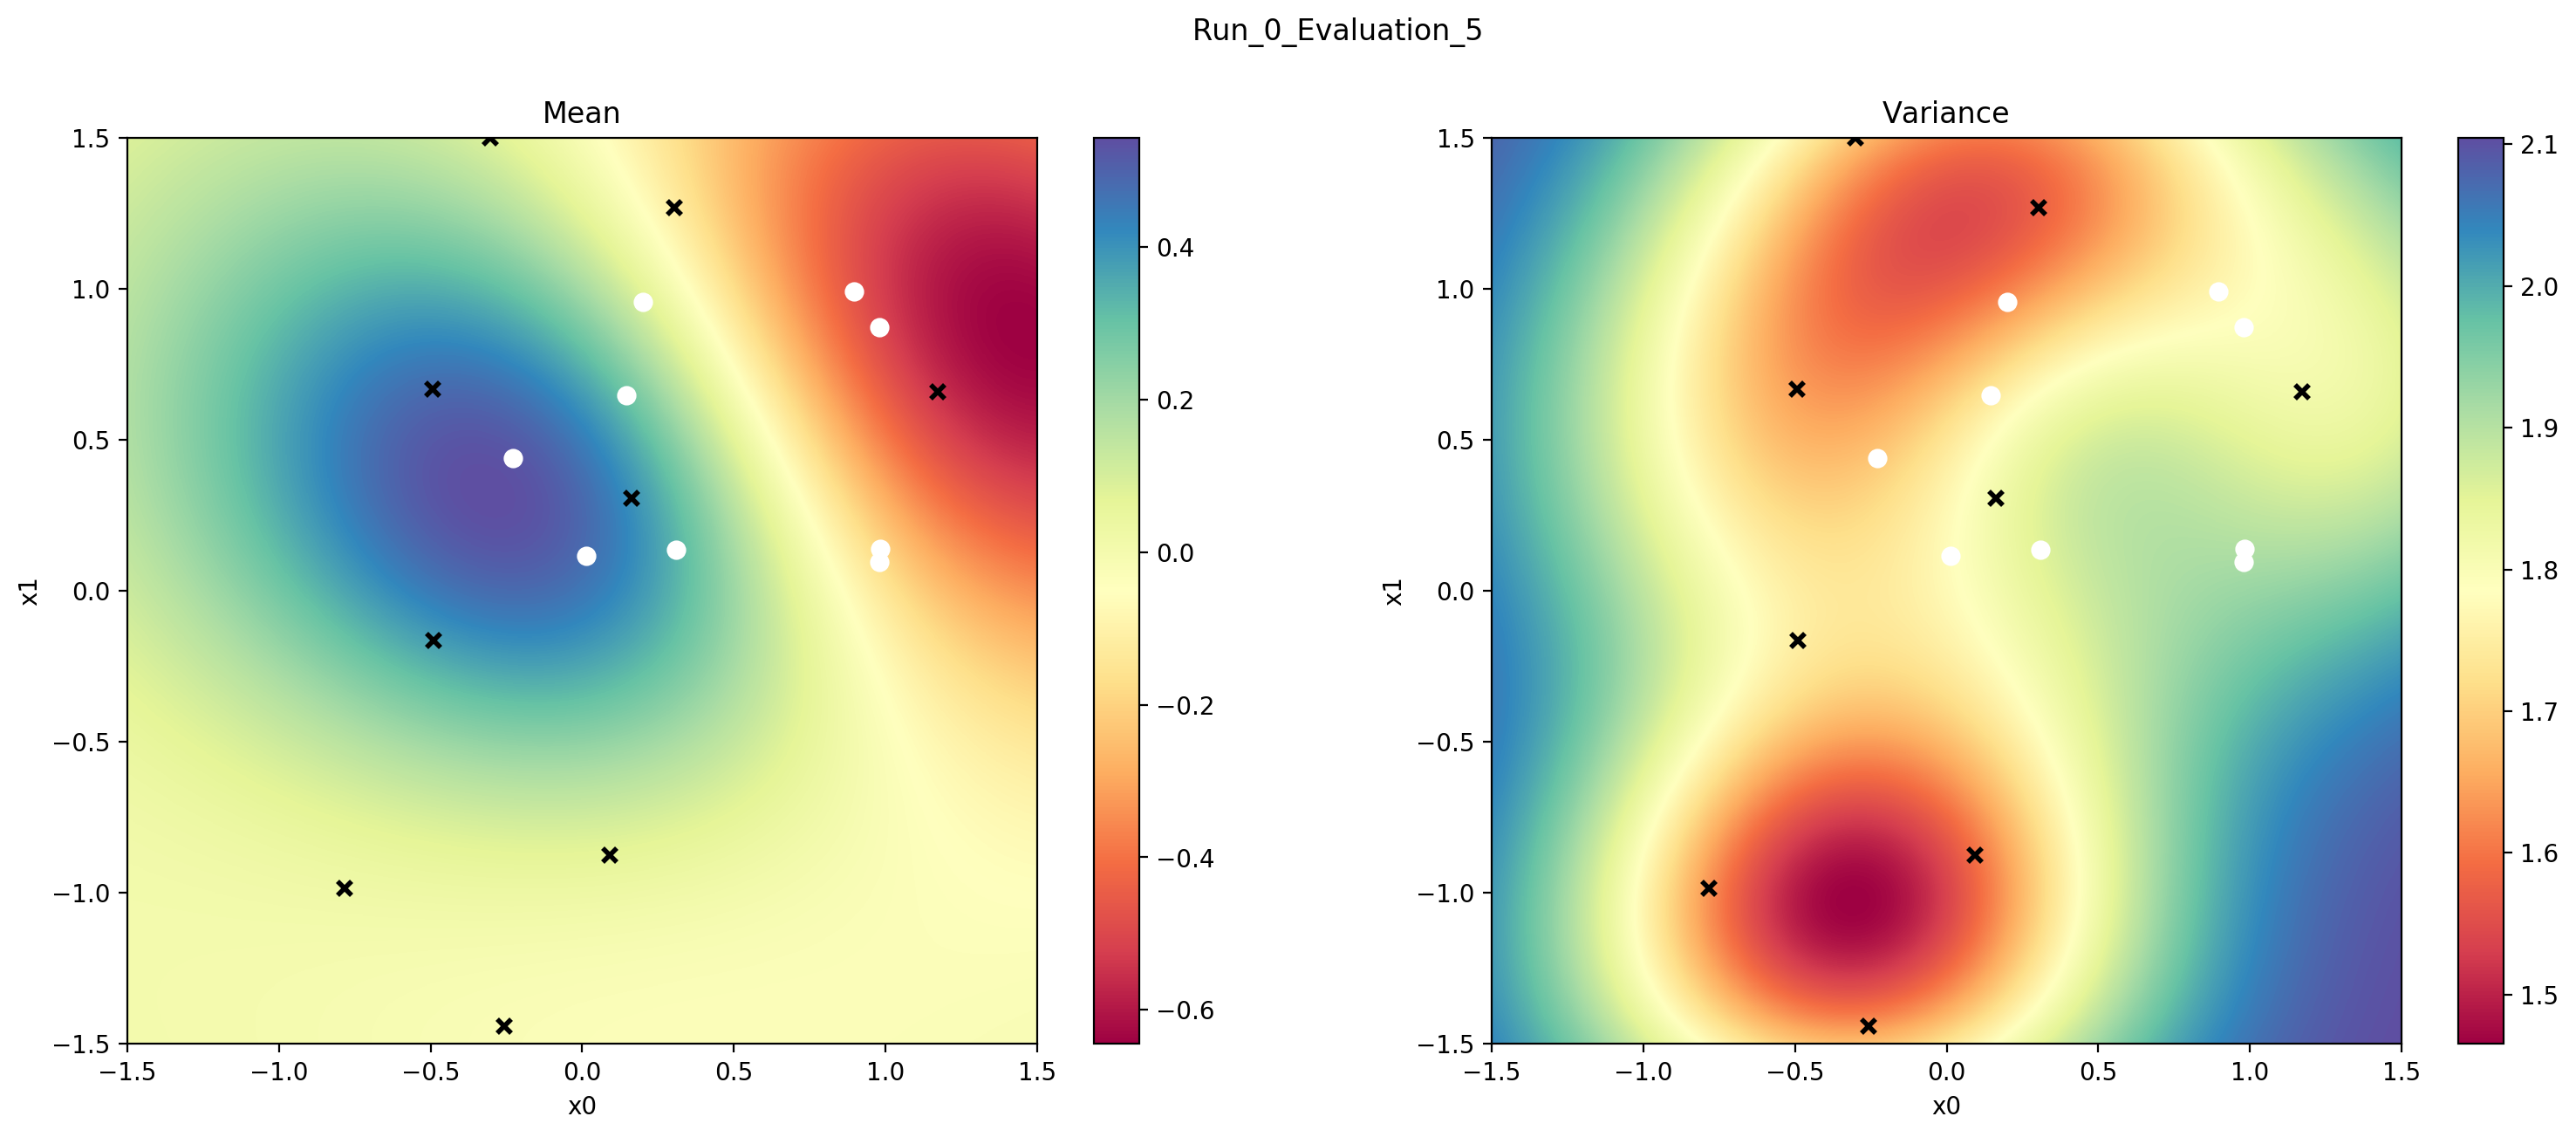

Beginning evaluation 6
Evaluation 6: Sampling maximizers
Loss at step 0: 67.95277072175924
Loss at step 500: -110.28215090248518
Loss at step 1000: -139.15152331076956
Loss at step 1500: -141.7718791601382
Loss at step 1846: -141.7985440771891
tf.Tensor(
[[0.66839511 0.        ]
 [1.         0.00746196]
 [0.         0.22788244]
 [0.15460591 1.        ]
 [1.         0.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [0.23119982 1.        ]
 [0.         1.        ]
 [1.         1.        ]
 [0.         0.        ]
 [1.         1.        ]
 [0.40420274 0.        ]
 [0.39161471 0.66919493]
 [1.         1.        ]
 [0.29925717 1.        ]
 [0.61862858 1.        ]
 [0.21128626 1.        ]
 [1.         0.9679344 ]], shape=(20, 2), dtype=float64)
Evaluation 6: Calculating I
Evaluation 6: Next query is tf.Tensor(
[[-0.2290356   0.43768234]
 [ 0.92906616  0.05352962]], shape=(2, 2), dtype=float64) with I value of 0.04987797986537221
Evaluation 6: Training mo

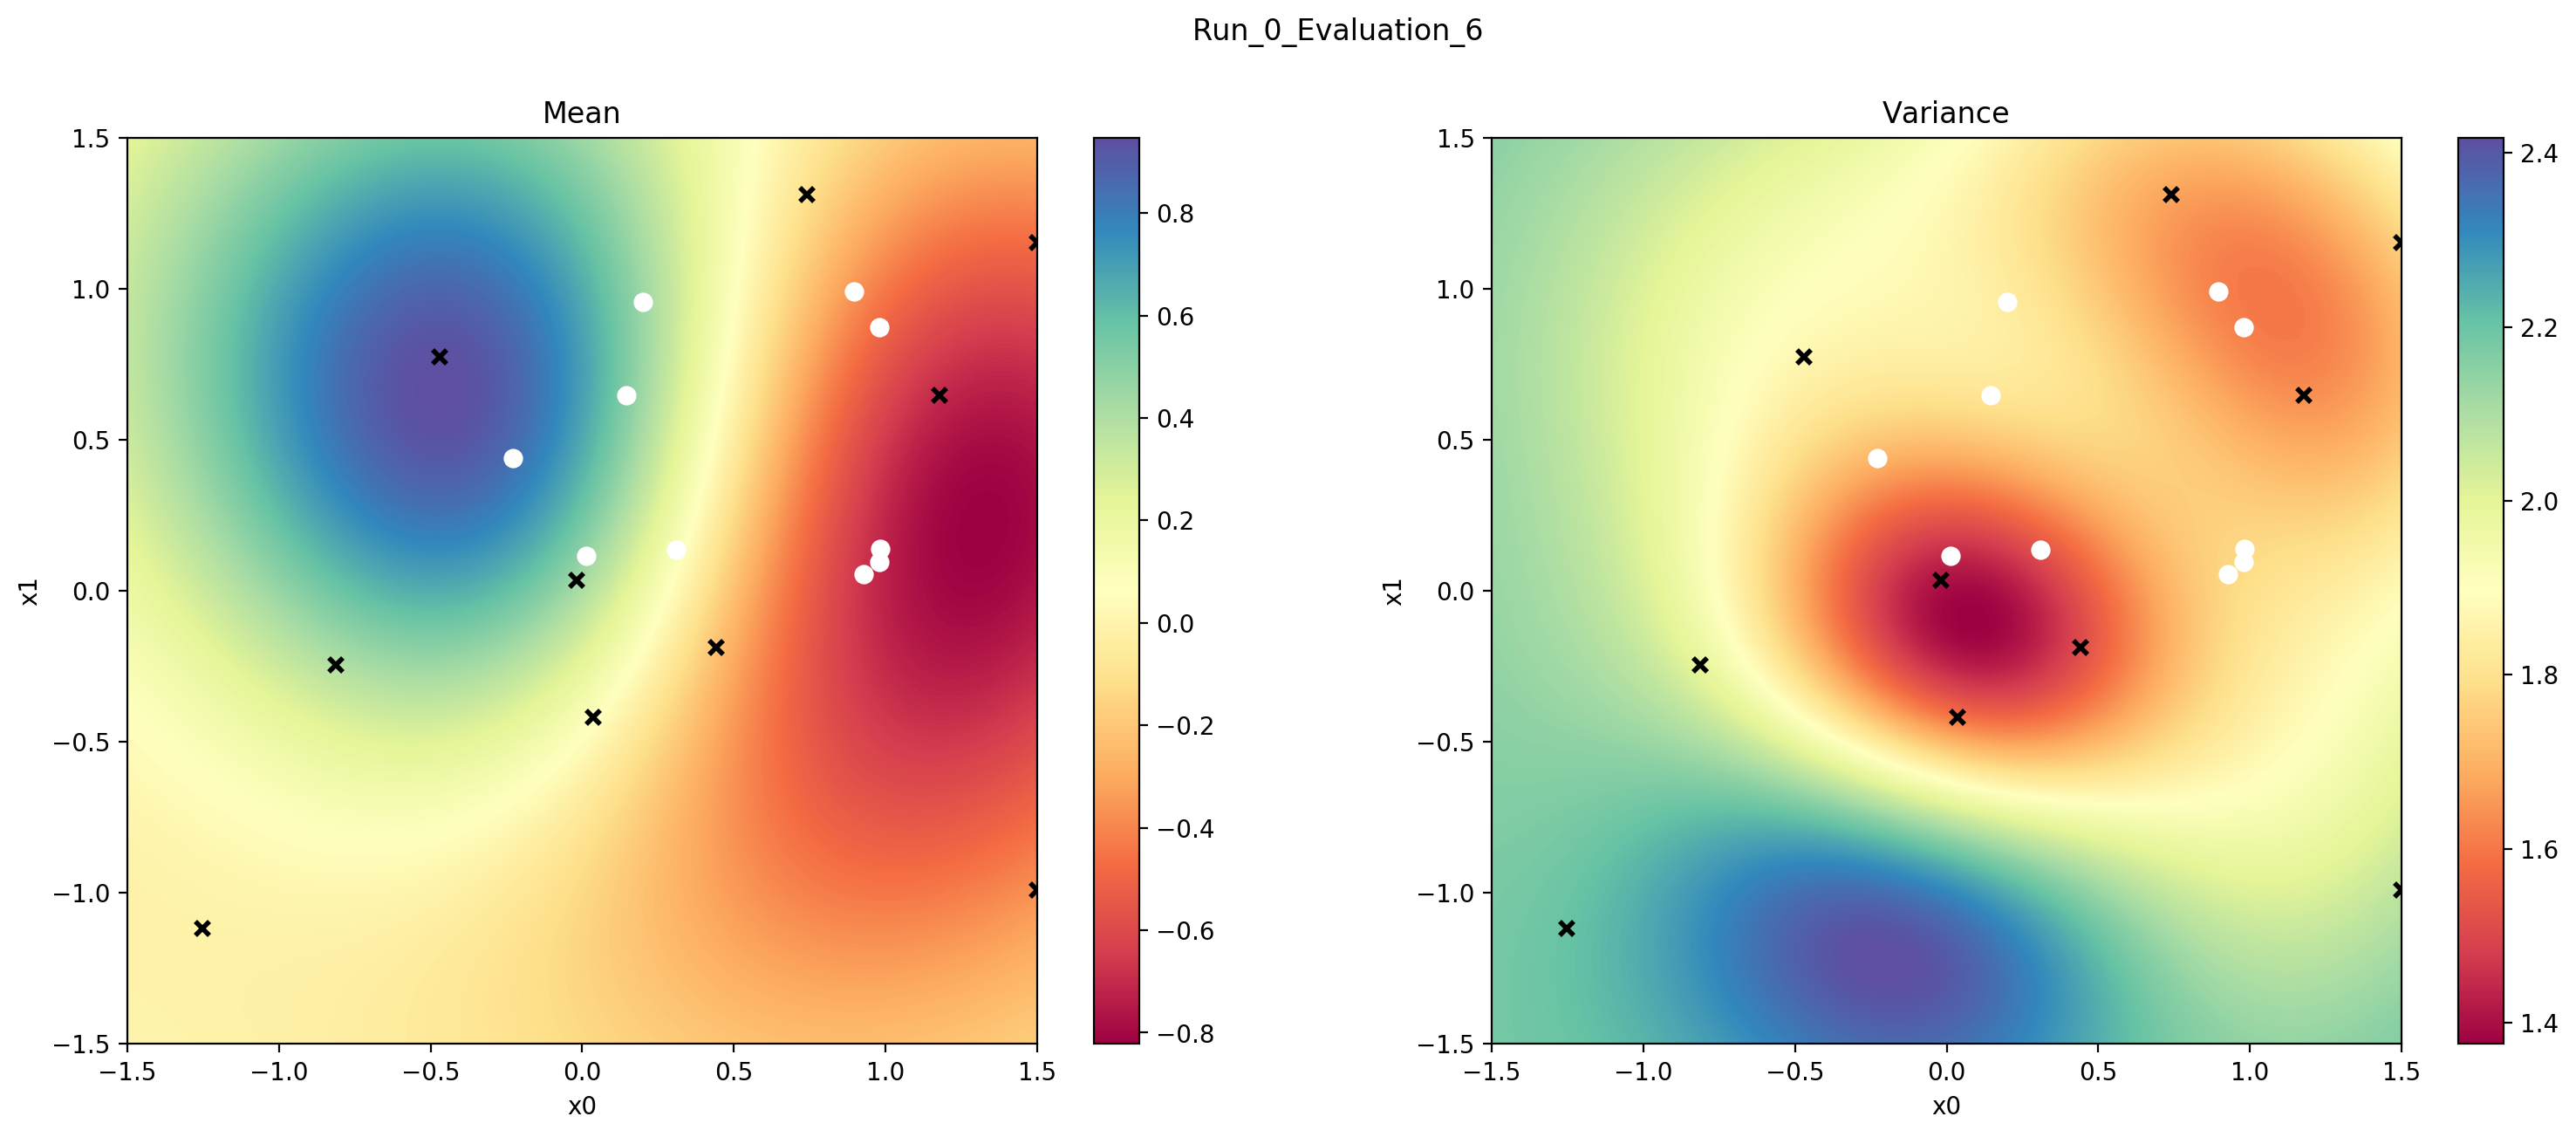

Beginning evaluation 7
Evaluation 7: Sampling maximizers
Loss at step 0: 29.697734247542208
Loss at step 500: -120.9685937178544
Loss at step 1000: -154.8573145824634
Loss at step 1500: -155.74166630843314
Loss at step 1776: -155.7748246885279
tf.Tensor(
[[0.         0.39252403]
 [1.         0.68435456]
 [0.93124325 0.        ]
 [0.         0.        ]
 [1.         0.        ]
 [0.71385388 1.        ]
 [0.         0.        ]
 [0.37971885 0.        ]
 [1.         1.        ]
 [0.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         0.78801078]
 [0.         0.20328809]
 [0.         0.50507295]
 [0.20275281 0.65078885]
 [1.         1.        ]
 [0.20185156 0.49304932]
 [0.         1.        ]], shape=(20, 2), dtype=float64)
Evaluation 7: Calculating I
Evaluation 7: Next query is tf.Tensor(
[[0.19891133 0.95612316]
 [0.10730103 0.00906   ]], shape=(2, 2), dtype=float64) with I value of 0.0488178071283688
Evaluation 7: Training model
I

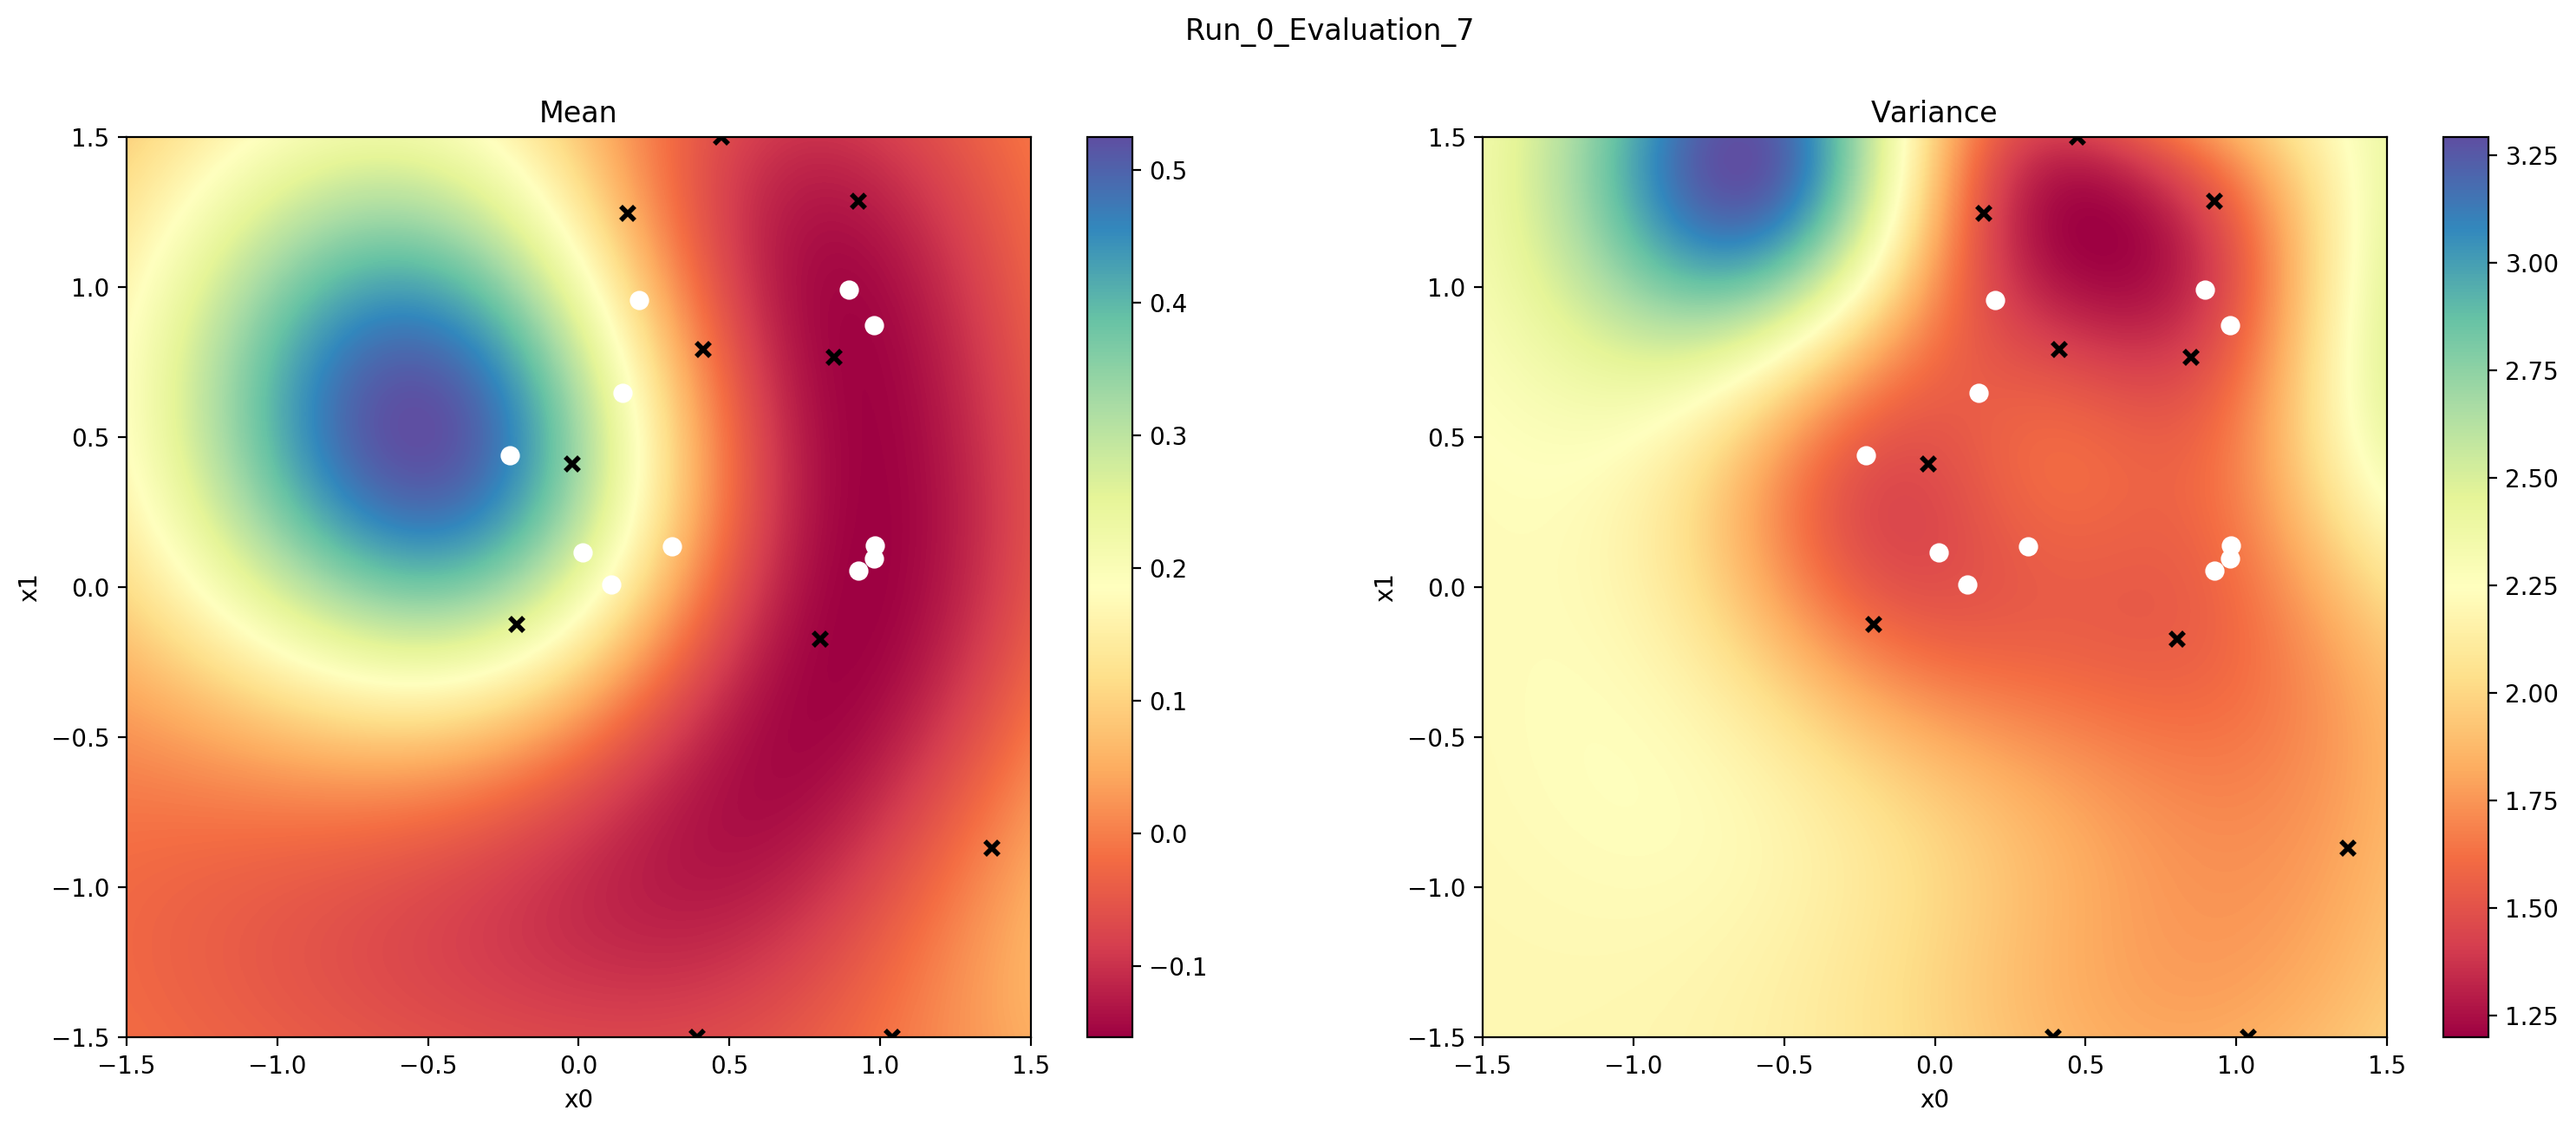

Beginning evaluation 8
Evaluation 8: Sampling maximizers
Loss at step 0: 15.618209973310858
Loss at step 500: -142.32050003093246
Loss at step 1000: -167.68141776225133
Loss at step 1500: -170.90056531611066
Loss at step 1781: -171.72557585309517
tf.Tensor(
[[0.46331733 1.        ]
 [0.         0.        ]
 [0.94879467 0.        ]
 [0.58149442 0.65437589]
 [1.         1.        ]
 [0.32003176 0.04187453]
 [0.7348435  0.2547416 ]
 [1.         0.87717696]
 [1.         0.93482409]
 [1.         0.89980488]
 [0.39634128 1.        ]
 [1.         1.        ]
 [0.13088624 1.        ]
 [0.75377469 0.        ]
 [1.         1.        ]
 [1.         1.        ]
 [1.         0.        ]
 [1.         1.        ]
 [0.         0.        ]
 [1.         0.        ]], shape=(20, 2), dtype=float64)
Evaluation 8: Calculating I
Evaluation 8: Next query is tf.Tensor(
[[0.98299011 0.13974578]
 [0.04928526 0.93345589]], shape=(2, 2), dtype=float64) with I value of 0.06425291559394858
Evaluation 8: Training mod

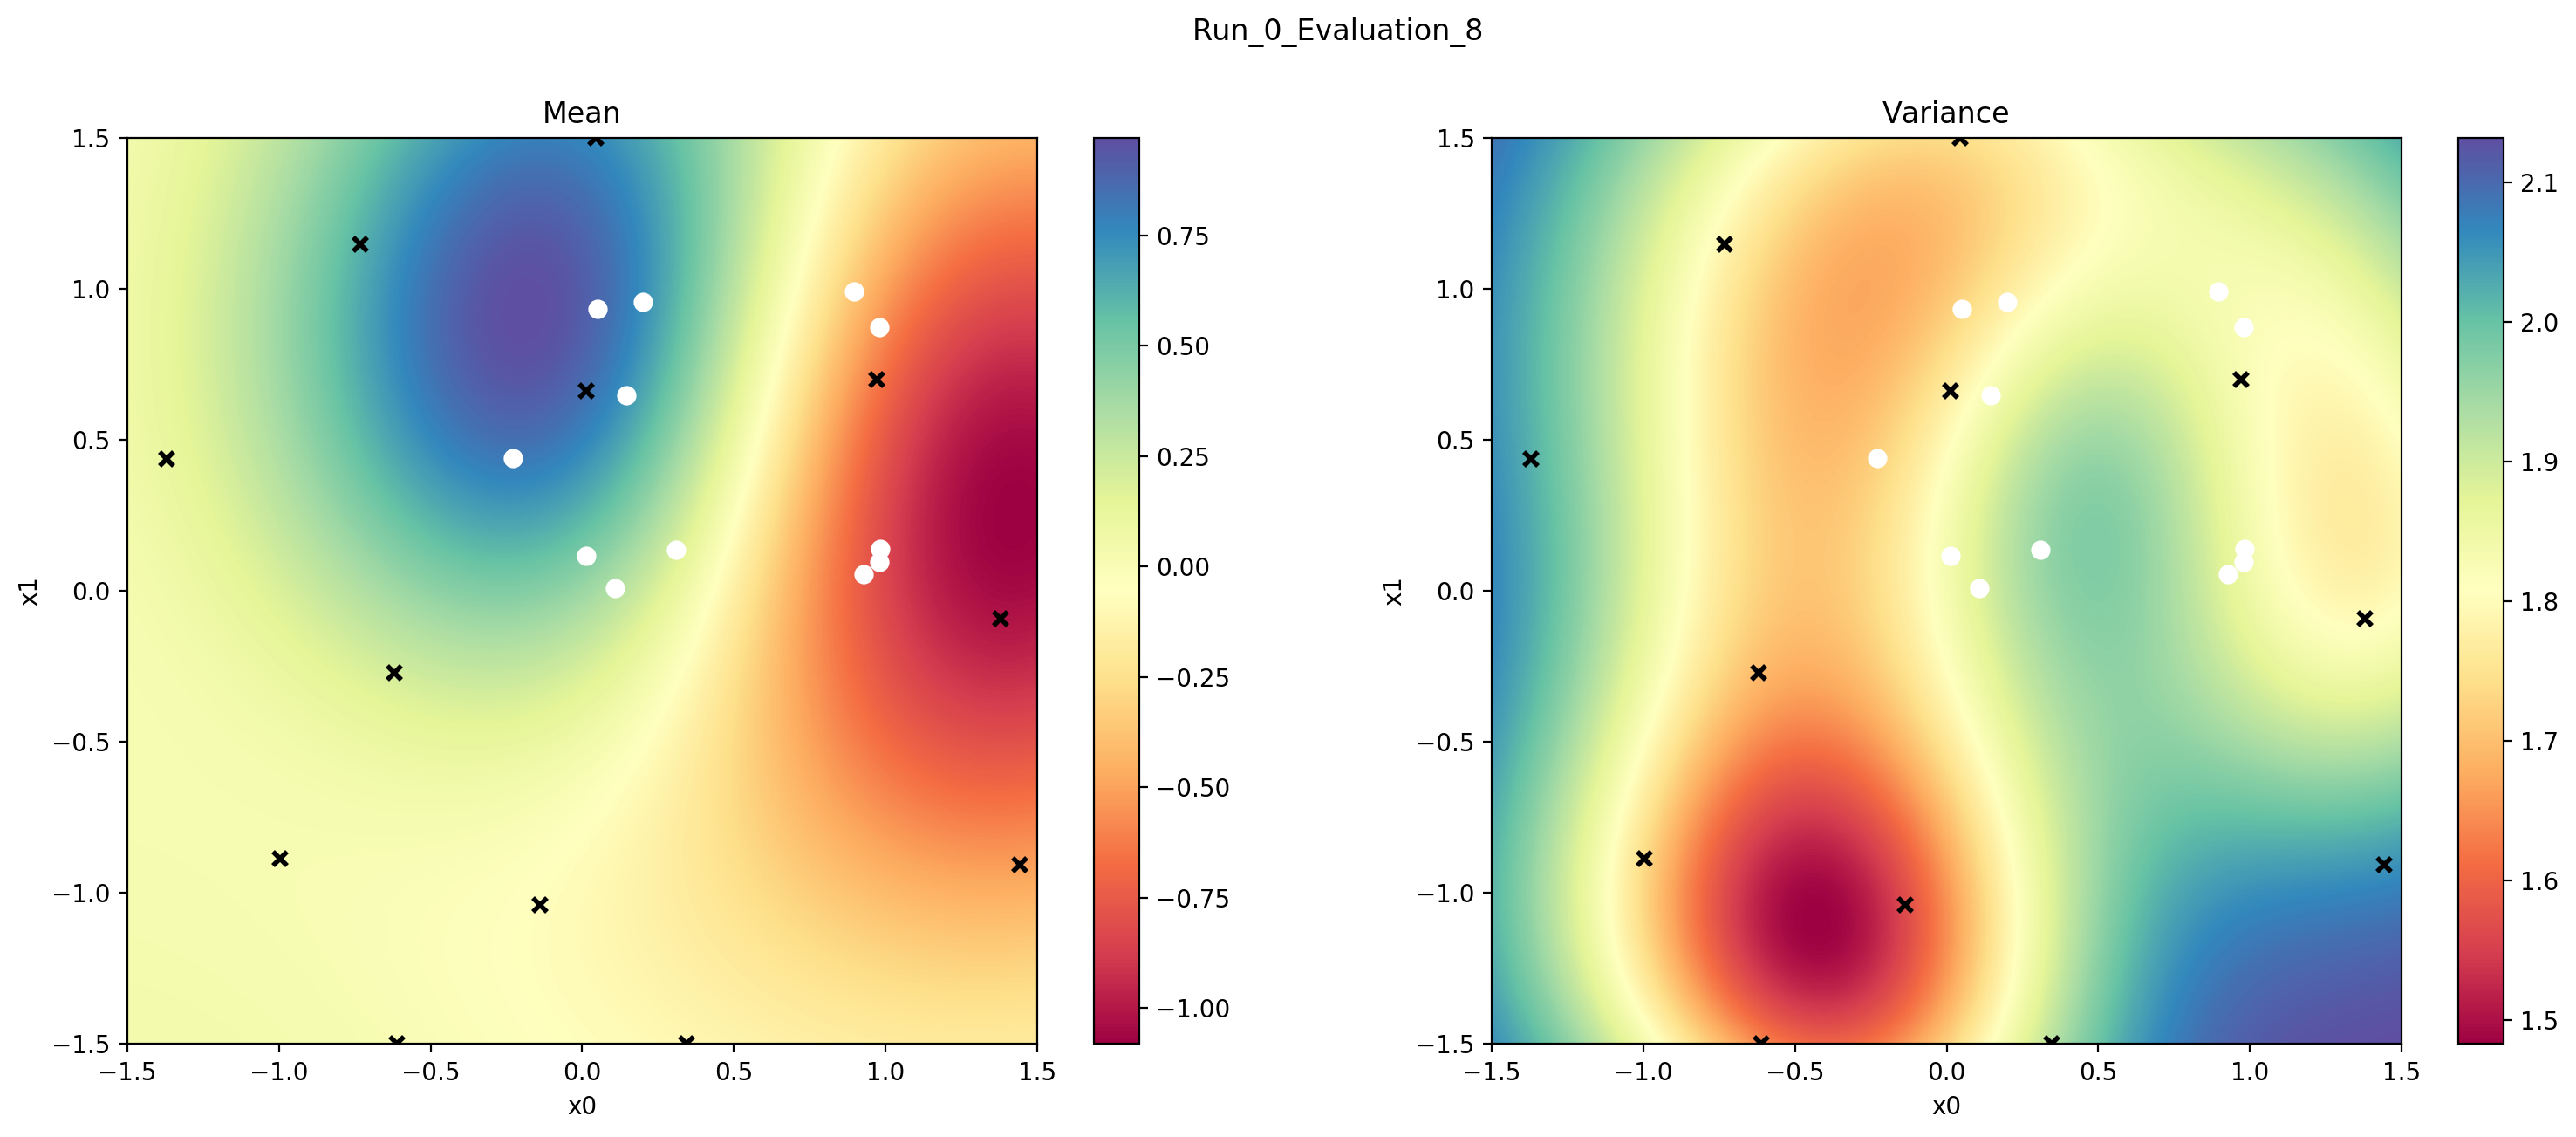

Beginning evaluation 9
Evaluation 9: Sampling maximizers
Loss at step 0: 21.45968611201569
Loss at step 500: -155.07215649006733
Loss at step 1000: -189.65511707221307
Loss at step 1500: -191.5970076256583
Loss at step 1947: -191.7181285758735
tf.Tensor(
[[0.07419888 0.16767682]
 [0.         0.65214145]
 [0.         1.        ]
 [0.         1.        ]
 [0.1858995  0.94016267]
 [0.04630949 0.54778247]
 [0.75394818 1.        ]
 [0.2932894  1.        ]
 [0.         0.73002184]
 [0.         1.        ]
 [1.         1.        ]
 [1.         0.33634761]
 [1.         1.        ]
 [0.         1.        ]
 [1.         1.        ]
 [1.         0.82739832]
 [0.         0.44994711]
 [0.         1.        ]
 [0.72856591 1.        ]
 [0.2064671  0.99486216]], shape=(20, 2), dtype=float64)
Evaluation 9: Calculating I
Evaluation 9: Next query is tf.Tensor(
[[0.10730103 0.00906   ]
 [0.09096934 0.9809794 ]], shape=(2, 2), dtype=float64) with I value of 0.04964480766864547
Evaluation 9: Training model


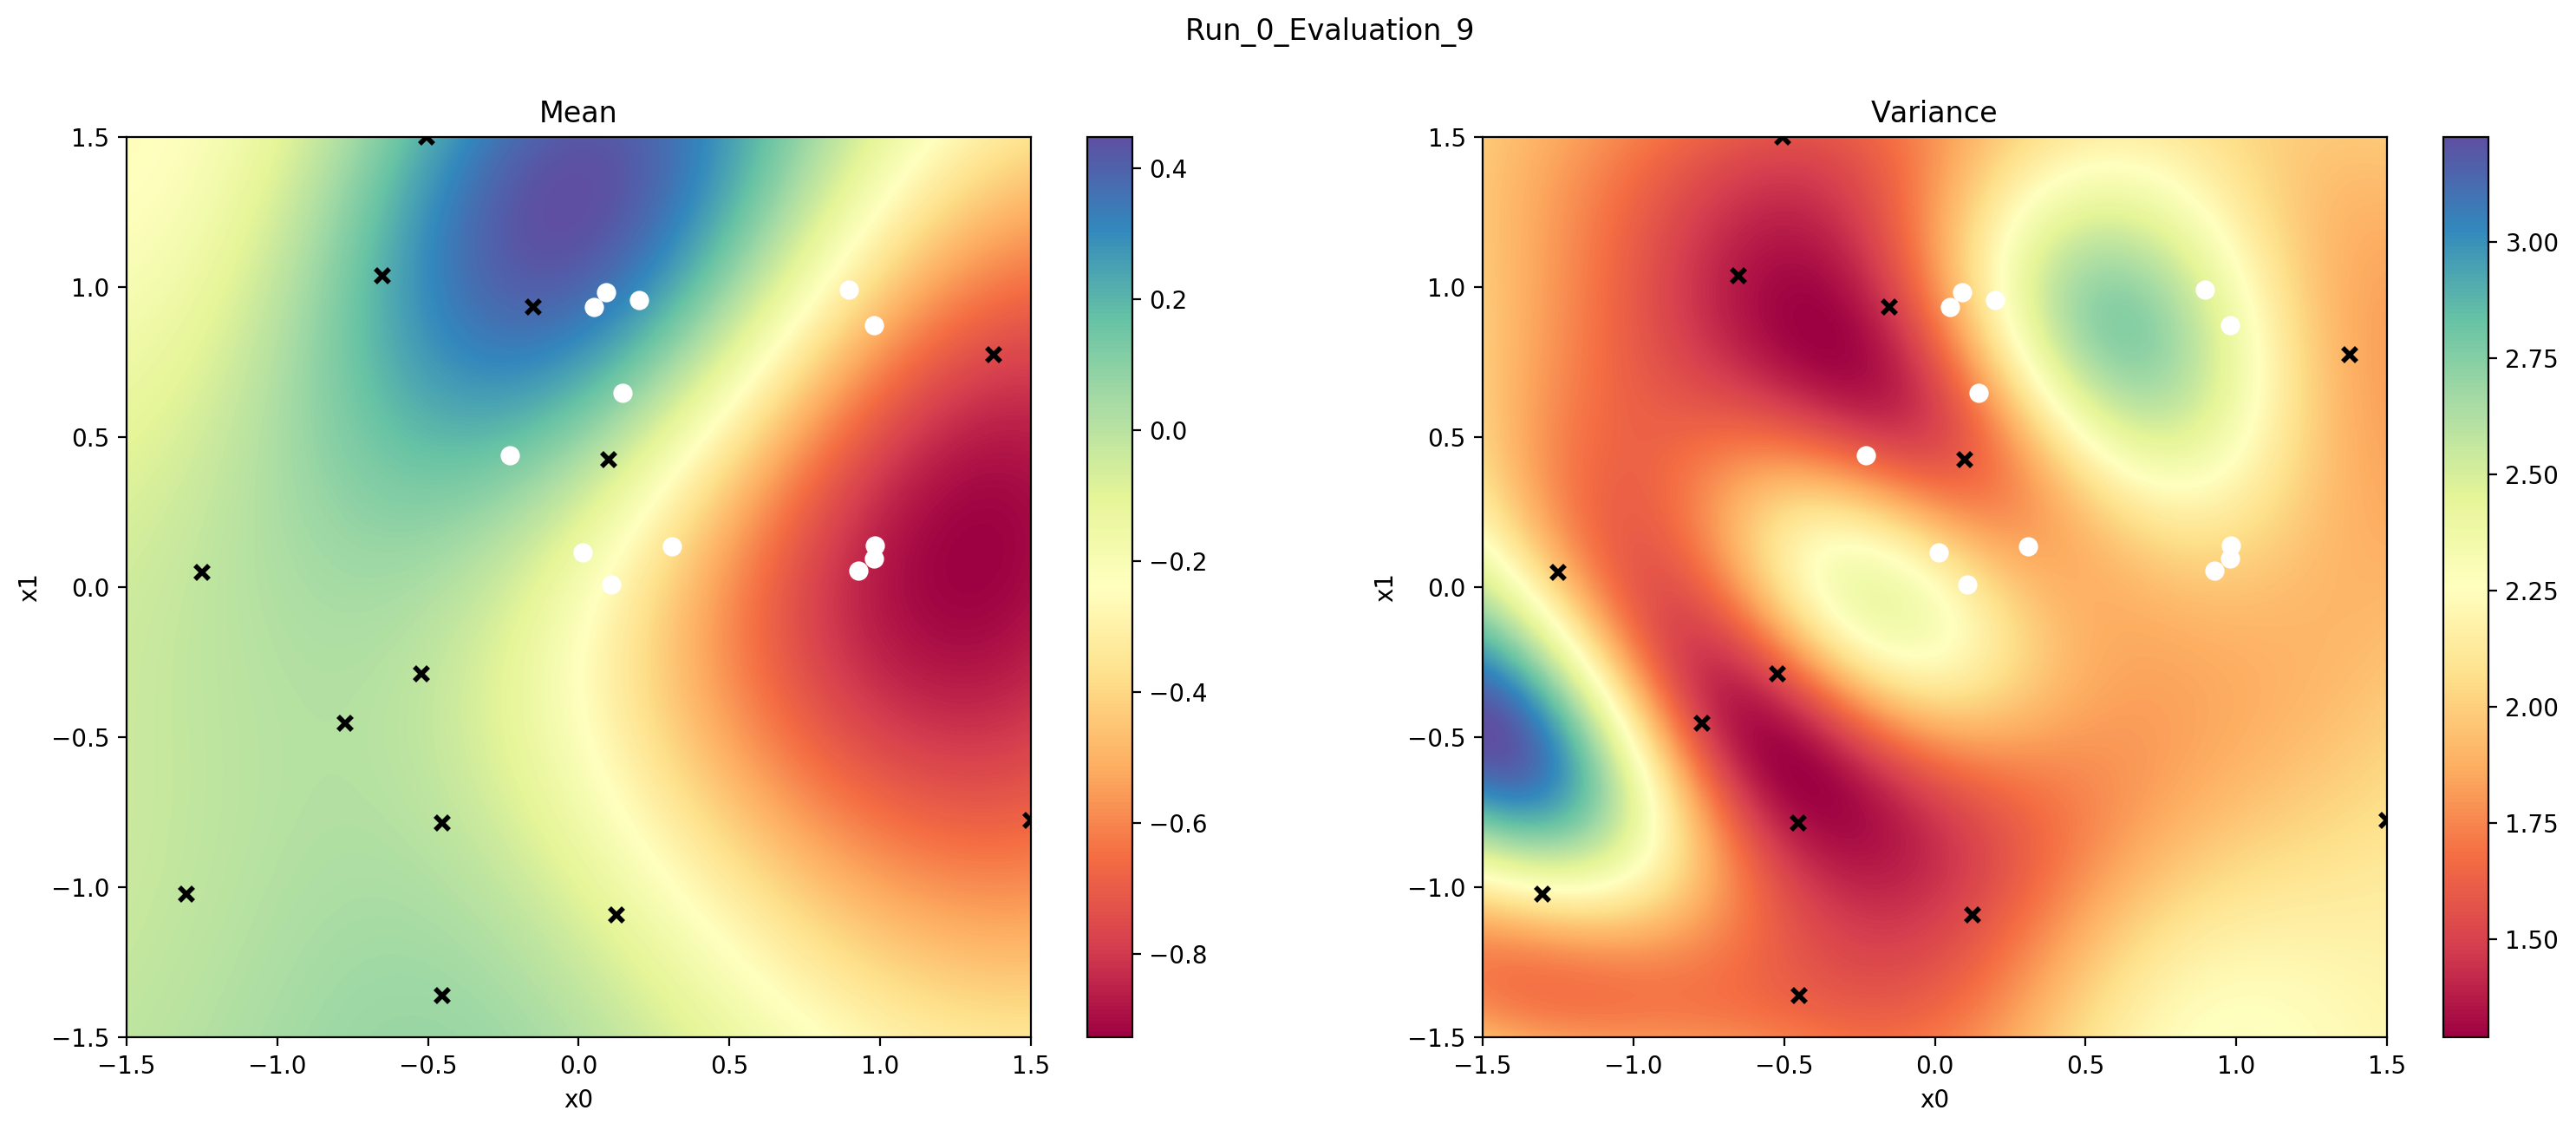

Beginning evaluation 10
Evaluation 10: Sampling maximizers
Loss at step 0: -27.224768254933615
Loss at step 500: -134.9839250268857
Loss at step 1000: -150.87421796420244
Loss at step 1500: -152.09431872911017
Loss at step 2000: -152.32197925191338
Loss at step 2447: -152.4078555918207
tf.Tensor(
[[0.13910437 1.        ]
 [1.         1.        ]
 [0.28782357 1.        ]
 [0.         1.        ]
 [0.86730731 0.        ]
 [1.         0.        ]
 [0.         0.52696887]
 [0.40008741 1.        ]
 [0.         1.        ]
 [0.         0.04878204]
 [0.52317109 0.09799348]
 [1.         0.08288678]
 [1.         1.        ]
 [0.         1.        ]
 [1.         0.79823677]
 [0.721486   1.        ]
 [0.22580289 1.        ]
 [0.7195356  1.        ]
 [0.         0.97491232]
 [0.27807979 0.        ]], shape=(20, 2), dtype=float64)
Evaluation 10: Calculating I
Evaluation 10: Next query is tf.Tensor(
[[0.01203622 0.1154843 ]
 [0.35321377 0.98306687]], shape=(2, 2), dtype=float64) with I value of 0.17

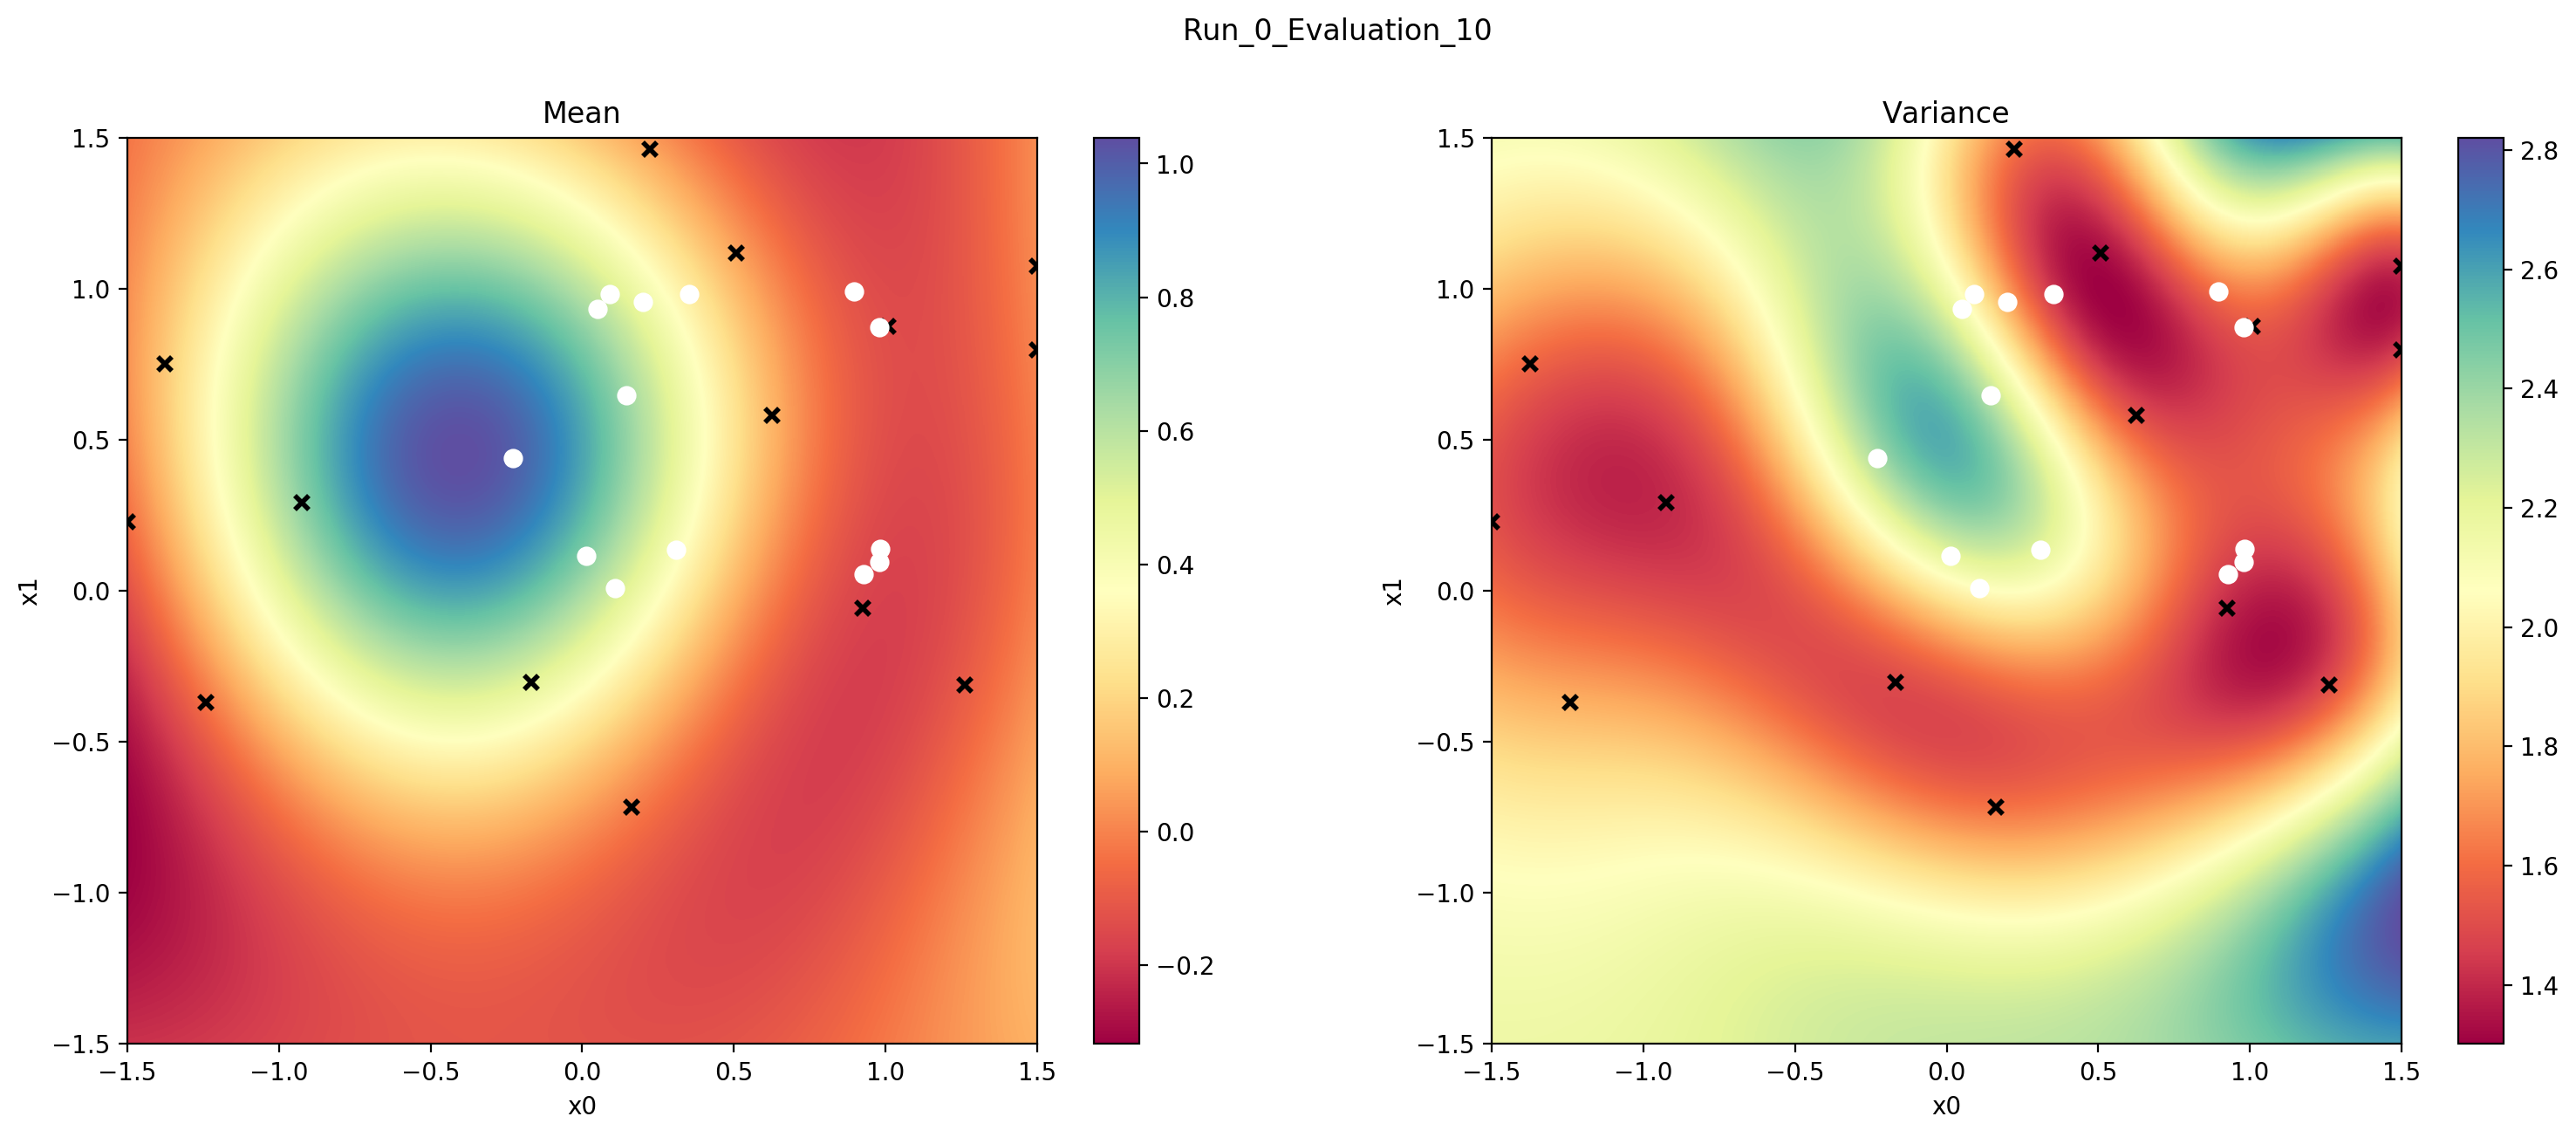

Beginning evaluation 11
Evaluation 11: Sampling maximizers
Loss at step 0: -28.13255391947595
Loss at step 500: -169.73458354930267
Loss at step 1000: -195.47610270688844
Loss at step 1500: -196.27720591522507
Loss at step 1889: -196.32883158360042
tf.Tensor(
[[1.         1.        ]
 [0.53437927 0.24398843]
 [0.72953964 1.        ]
 [0.         0.        ]
 [0.80725594 0.06674047]
 [1.         1.        ]
 [1.         1.        ]
 [0.         0.72947734]
 [0.21569447 0.16068718]
 [1.         1.        ]
 [0.1614895  1.        ]
 [0.         0.91219973]
 [0.         0.62221947]
 [1.         0.6284722 ]
 [0.25160126 0.        ]
 [0.11803525 1.        ]
 [0.         0.        ]
 [0.         0.51734444]
 [1.         1.        ]
 [1.         1.        ]], shape=(20, 2), dtype=float64)
Evaluation 11: Calculating I
Evaluation 11: Next query is tf.Tensor(
[[0.89667129 0.99033895]
 [0.00593875 0.43463252]], shape=(2, 2), dtype=float64) with I value of 0.14295920665497255
Evaluation 11: Trainin

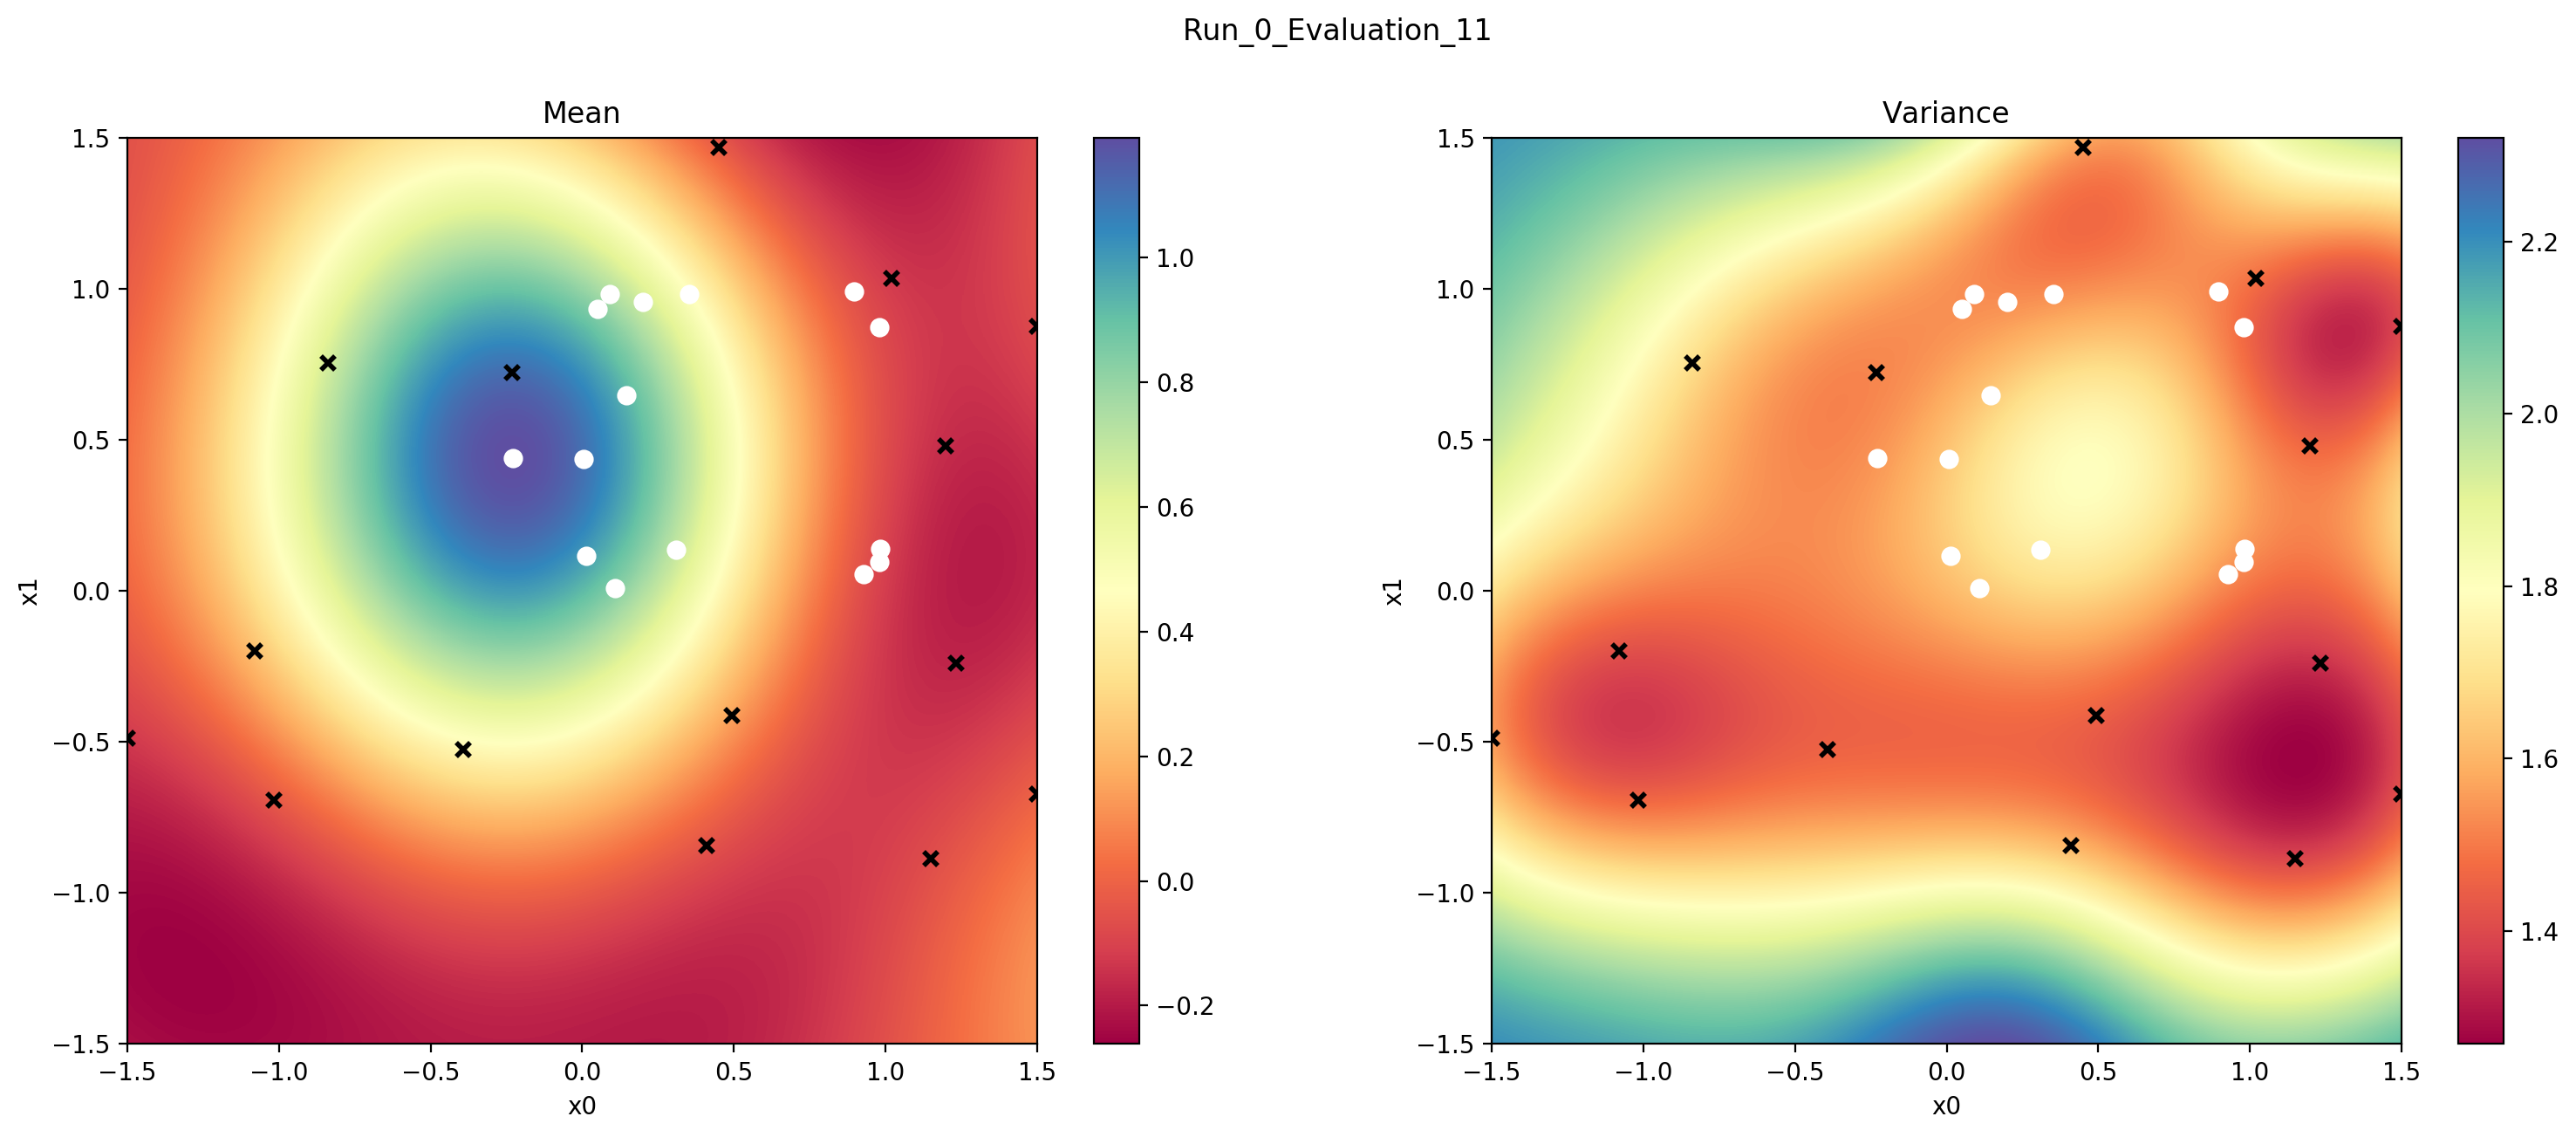

Beginning evaluation 12
Evaluation 12: Sampling maximizers
Loss at step 0: 25.583245775772188
Loss at step 500: -116.9296387333936
Loss at step 1000: -147.77164186386162
Loss at step 1500: -149.35165499775508
Loss at step 2000: -149.39773648355333
Loss at step 2500: -149.55003867338127
tf.Tensor(
[[0.40845231 1.        ]
 [1.         1.        ]
 [1.         0.83350883]
 [1.         0.4708902 ]
 [1.         0.71178884]
 [1.         1.        ]
 [0.82979901 0.42868692]
 [0.19522216 0.75698002]
 [1.         0.32923311]
 [1.         0.        ]
 [0.50727031 0.08503887]
 [0.         1.        ]
 [1.         0.34334882]
 [0.14234096 0.        ]
 [0.12909968 0.42439568]
 [0.         1.        ]
 [0.24682241 1.        ]
 [1.         1.        ]
 [0.         0.41770078]
 [1.         1.        ]], shape=(20, 2), dtype=float64)
Evaluation 12: Calculating I
Evaluation 12: Next query is tf.Tensor(
[[0.09096934 0.9809794 ]
 [0.26768404 0.0936607 ]], shape=(2, 2), dtype=float64) with I value of 0.04

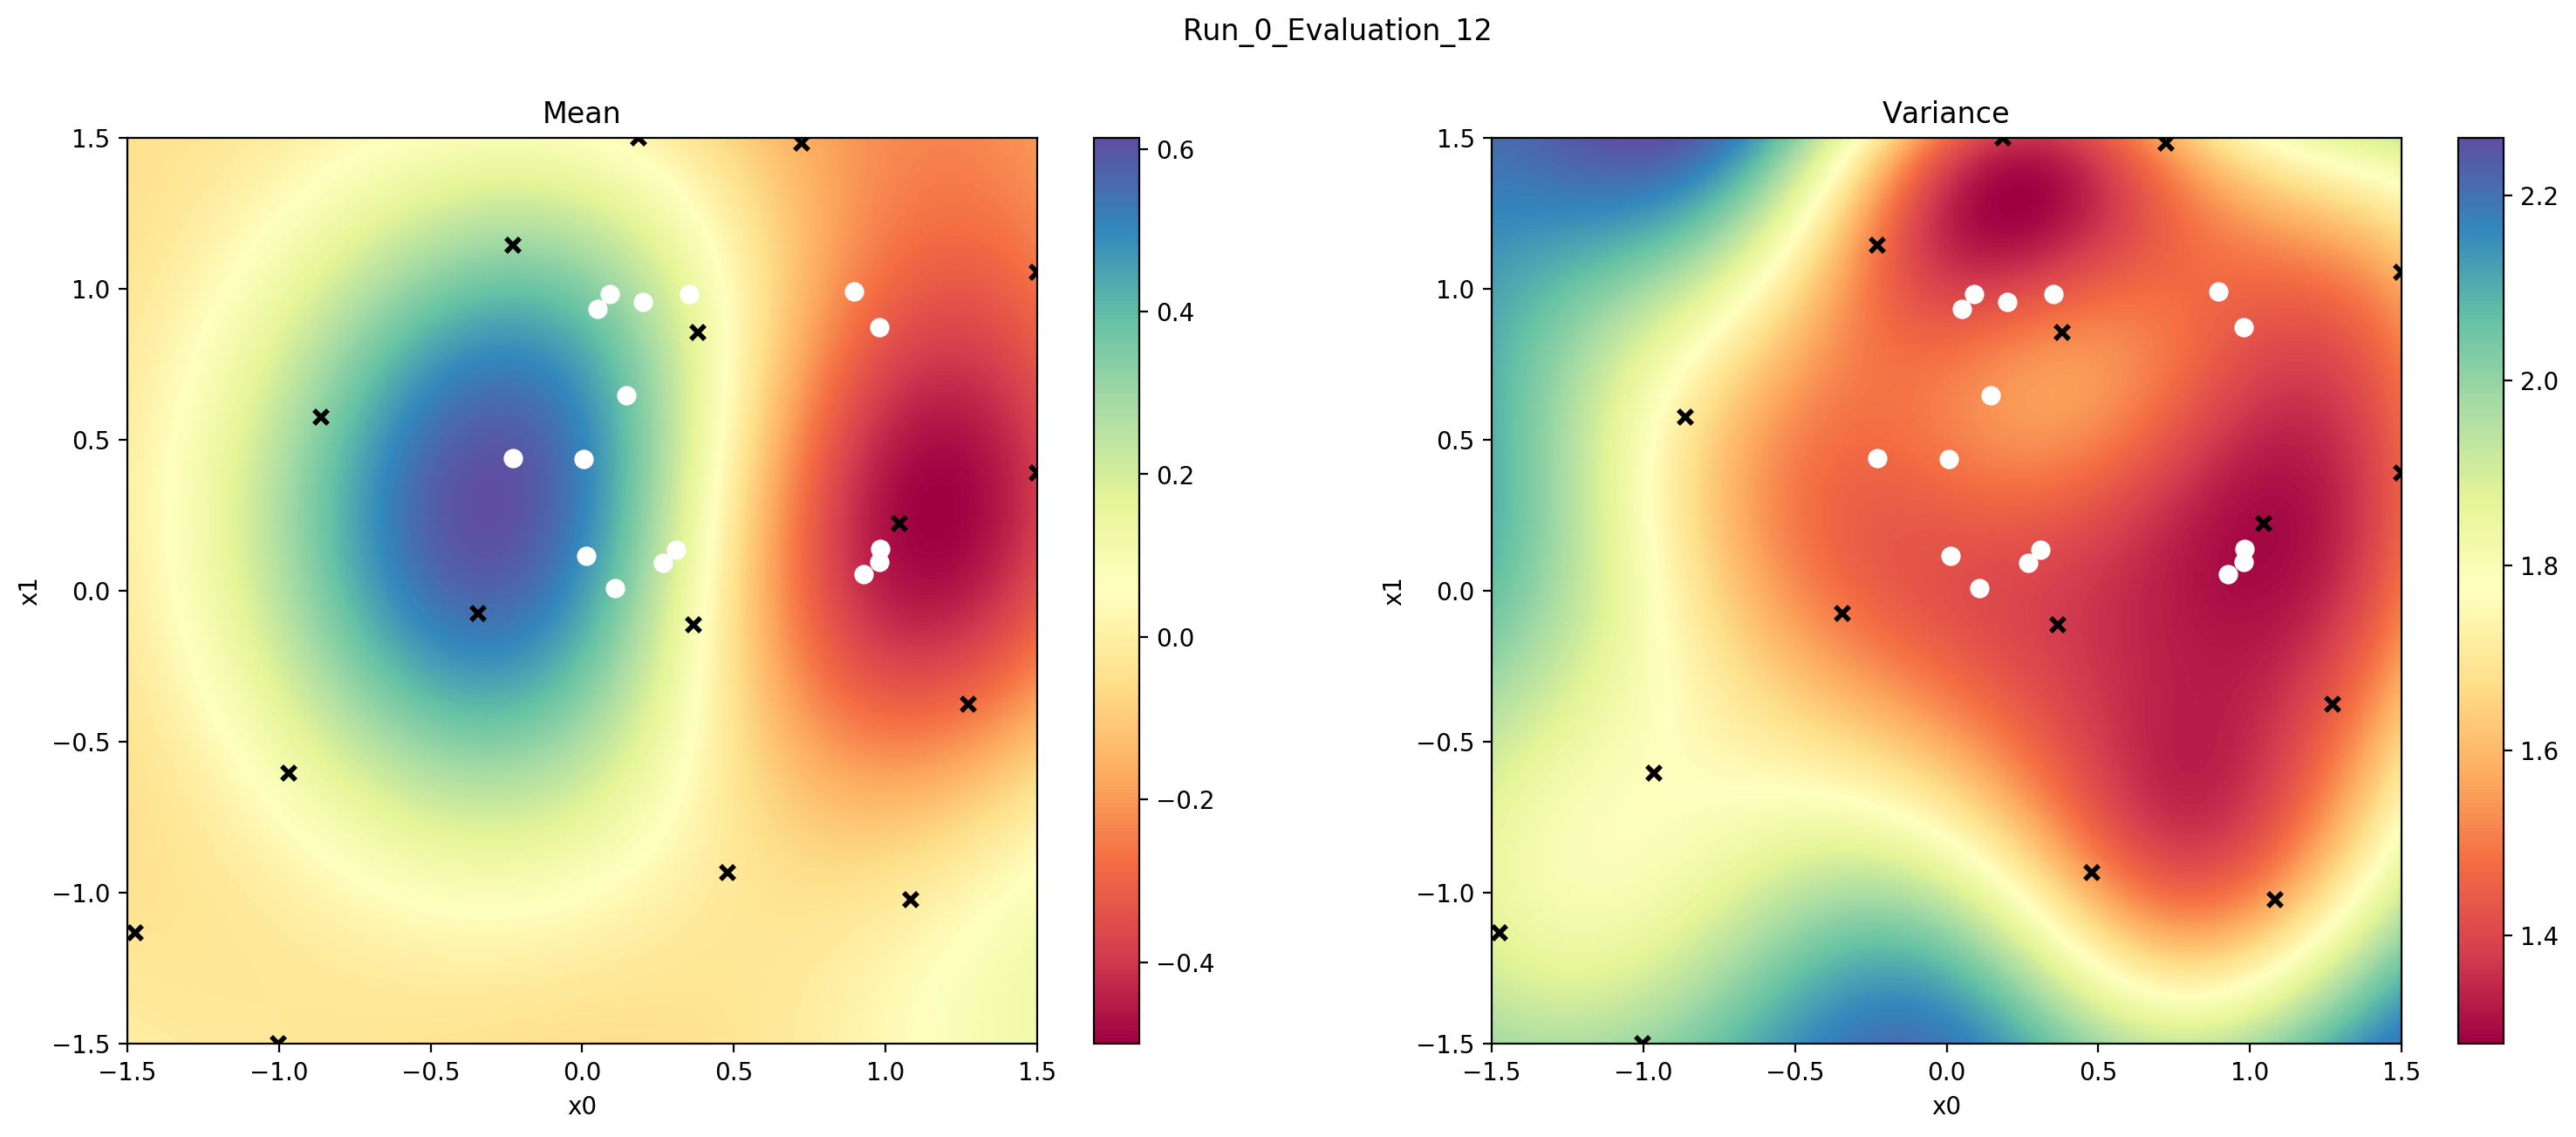

Beginning evaluation 13
Evaluation 13: Sampling maximizers
Loss at step 0: 33.229957081203054
Loss at step 500: -106.96841901936673
Loss at step 1000: -128.61611576253458
Loss at step 1500: -135.39110073868954
Loss at step 1929: -137.41031402500477
tf.Tensor(
[[1.         1.        ]
 [0.         0.        ]
 [0.         1.        ]
 [0.91195643 1.        ]
 [0.         0.32098724]
 [1.         0.        ]
 [0.60291831 0.38513806]
 [0.65622385 1.        ]
 [0.         0.        ]
 [0.         0.47878516]
 [1.         1.        ]
 [1.         1.        ]
 [1.         1.        ]
 [0.         0.50625053]
 [0.         0.        ]
 [1.         0.13424859]
 [1.         1.        ]
 [0.75522015 0.        ]
 [0.         0.        ]
 [0.33521935 1.        ]], shape=(20, 2), dtype=float64)
Evaluation 13: Calculating I
Evaluation 13: Next query is tf.Tensor(
[[0.10730103 0.00906   ]
 [0.16510813 0.95860129]], shape=(2, 2), dtype=float64) with I value of 0.04112767282271858
Evaluation 13: Trainin

In [ ]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Sample possible next queries
        
        samples = PBO.acquisitions.pes.sample_inputs(inputs, num_samples, num_choices)

        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.fourier_features.sample_maximizers(X=inducing_vars,
                                                            count=num_maximizers,
                                                            n_init=10,
                                                            D=100,
                                                            model=model)
        print(maximizers)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = get_noisy_observation(X, objective)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()